# Example 1: 2-D fault network extraction from a numerical model
This example describes how to extract a 2-D fault network from a numerical model simulating continental rifting. This example is based on the study of Naliboff et al. (2020).

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
# !pip3 install git+https://github.com/thilowrona/fatbox.git

download the tutorials:

In [2]:
# !git clone https://github.com/thilowrona/fatbox_tutorials

Now we can load the python packages that we need:

In [2]:
import numpy as np 
import networkx as nx
import pickle
import cv2
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance_matrix

from sys import stdout

# from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
# from fatbox.edits import label_components, simplify
# from fatbox.plots import plot_components

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

import cartopy.crs as ccrs
import pyvista as pv
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
import geovista as gv
from geovista.common import to_cartesian
from skimage import measure
from scipy.interpolate import griddata
from cartopy.util import add_cyclic_point

from joblib import Parallel, delayed
import networkx as nx
import cartopy.util as cutil

num_cores =-1





# from geovista.common import to_xyz

## Fault extraction

First, we load our data - a strain rate map extracted just below the surface of the model:

In [4]:
# file_path = '/Volumes/Jerry/global_models_3d/R01e_Rodinia_2GPa_Mantle_C20MPa_f003_LR/solution/solution_surface-00110.0000.vtu'
file_path = '/Volumes/Jerry/global_models_3d/V06a_R01f_Rodinia_2GPa_llsvps_ps_1x50My_init_2Myint/solution/solution_surface-00022.0000.vtu'

plot_figures = 'true'
data = pv.read(file_path)
print(data)

# Display the names of the arrays in point data
print("Point Data Arrays:")
for name in data.point_data.keys():
    print(f" - {name}")

# # Display the names of the arrays in cell data
# print("Cell Data Arrays:")
# for name in data.cell_data.keys():
#     print(f" - {name}")

# Displaying the actual arrays (optional, for debugging purposes)
print("\nActual Point Data Arrays:")
for name, array in data.point_data.items():
    print(f"\n{name}:")
    print(array)

# print("\nActual Cell Data Arrays:")
# for name, array in data.cell_data.items():
#     print(f"\n{name}:")
#     print(array)


UnstructuredGrid (0x29f07afe0)
  N Cells:    835584
  N Points:   1880064
  X Bounds:   -6.371e+06, 6.371e+06
  Y Bounds:   -6.371e+06, 6.371e+06
  Z Bounds:   -6.371e+06, 6.371e+06
  N Arrays:   11
Point Data Arrays:
 - surface_velocity
 - surface_strain_rate_tensor
 - surface_stress
 - surface_p
 - surface_T
 - surface_continent
 - surface_asthenosphere
 - surface_llsvps
 - surface_plastic_strain

Actual Point Data Arrays:

surface_velocity:
[[ 6.9132322e-03  0.0000000e+00  5.0478582e-03]
 [ 7.0207254e-03 -1.9685831e-05  5.1557673e-03]
 [ 7.1282191e-03 -3.9371662e-05  5.2636759e-03]
 ...
 [-3.7437461e-03 -7.0203687e-03 -1.7438198e-02]
 [-3.7710969e-03 -6.9834050e-03 -1.7381093e-02]
 [-3.7984753e-03 -6.9464510e-03 -1.7324079e-02]]

surface_strain_rate_tensor:
[[ 7.44244904e-17  1.77895109e-15  7.48228043e-18 ...  7.48228043e-18
   3.48861901e-16 -3.87446927e-19]
 [ 7.44244904e-17  1.77895109e-15  7.48228043e-18 ...  7.48228043e-18
   3.48861901e-16 -3.87446927e-19]
 [ 7.44244904e-17  

In [5]:
# Access the strain rate tensor array
strain_rate_tensor = data.point_data['surface_strain_rate_tensor']

# Calculate the magnitude (Frobenius norm) of the strain rate tensor
strain_rate_magnitude = np.linalg.norm(strain_rate_tensor, axis=1)

# Calculate the log10 of the strain rate magnitude
strain_rate_magnitude_log10 = np.log10(strain_rate_magnitude)

# Add the log10 magnitude array to the dataset for visualization or further analysis
data.point_data['strain_rate_magnitude'] = strain_rate_magnitude_log10

# Calculate radius and topography
radius = np.sqrt(data.points[:, 0]**2 + data.points[:, 1]**2 + data.points[:, 2]**2)
topography = radius - 6371000  # Assuming Earth's radius in meters

# Convert coordinates to degrees
longitude = np.arctan2(data.points[:, 1], data.points[:, 0]) * 180 / np.pi
latitude = np.arcsin(data.points[:, 2] / radius) * 180 / np.pi

print(longitude,latitude)
# Add topography, longitude, and latitude as scalar arrays to the mesh
data.point_data['Topography'] = topography
data.point_data['Longitude'] = longitude
data.point_data['Latitude'] = latitude

if plot_figures.lower() == 'true':
    # Optionally, visualize the result
    plotter = pv.Plotter()
    plotter.add_mesh(data, scalars='strain_rate_magnitude', cmap='viridis', clim=[-16, -14])
    # plotter.add_scalar_bar(title='Log10 Strain Rate Magnitude')
    plotter.show()


[-90.       -90.60477  -91.20967  ...  19.766382  19.935001  20.103909] [  0.          0.6047375   1.2094077 ... -18.684807  -18.82701
 -18.969065 ]


In [4]:

# # data = pd.read_csv('/Volumes/Jerry/global_models_3d/R01e_Rodinia_2GPa_Mantle_C20MPa_f003_LR/solution_surface.pvd')
# data_array = data.to_numpy()  # Convert DataFrame to numpy array

# print(data)
# # Access the 'strain_rate' column and slice it
# strain_rate = data['strain_rate'].values

# # print(strain_rate)
# # strain_rate_sliced = strain_rate[:400, 250:450]


In [6]:
# Define grid of longitude and latitude for interpolation
lon_grid, lat_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-90, 90, 180))

# # Interpolate strain_rate_magnitude_log10 onto lon_grid, lat_grid
# strain_rate_magnitude_interp = griddata((longitude, latitude), strain_rate_magnitude_log10,
#                                         (lon_grid, lat_grid), method='linear')

##Let's parallelised griddata that takes most of the time here time goes from 1:22min to 6sec here
# Function to perform griddata interpolation
def interpolate_strain_rate(method):
    return griddata((longitude, latitude), strain_rate_magnitude_log10, (lon_grid, lat_grid), method=method)

# Parallelize the interpolation step
strain_rate_magnitude_interp, strain_rate_magnitude_nearest = Parallel(n_jobs=num_cores)(
    delayed(interpolate_strain_rate)(method) for method in ['linear', 'nearest']
)

# Handle missing values in the linear interpolation by filling with nearest interpolation
strain_rate_magnitude_interp = np.where(np.isnan(strain_rate_magnitude_interp), strain_rate_magnitude_nearest, strain_rate_magnitude_interp)

# Apply a threshold to the interpolated strain rate magnitude
threshold_value = 5e-16
threshold = simple_threshold_binary(10**strain_rate_magnitude_interp, threshold_value)

# Perform skeletonization on the thresholded data
skeleton = skeleton_guo_hall(threshold)


# from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming `skeleton` is your input image after skeletonization

# Label connected components
labels = measure.label(skeleton, connectivity=2)

# Get the properties of labeled regions
props = measure.regionprops(labels)

# Filter out small objects based on area or other properties
min_area = 4  # Set this according to your needs
skeleton_cleaned = np.zeros_like(skeleton, dtype=bool)
for prop in props:
    if prop.area >= min_area:
        skeleton_cleaned[labels == prop.label] = 1

#here parallelising doesn't make it faster
# # Extract simple properties for parallel processing
# regions = [(prop.area, prop.label) for prop in props]

# # Function to filter and clean skeleton regions
# def clean_skeleton_region(area, label, min_area, labels, skeleton_cleaned):
#     if area >= min_area:
#         skeleton_cleaned[labels == label] = 1
#     return skeleton_cleaned

# # Filter out small objects based on area using parallel processing
# min_area = 4  # Set this according to your needs
# skeleton_cleaned = np.zeros_like(skeleton, dtype=bool)

# # Parallelize the region filtering with simpler inputs
# results = Parallel(n_jobs=num_cores)(delayed(clean_skeleton_region)(area, label, min_area, labels, skeleton_cleaned) for area, label in regions)

# # Combine the results
# skeleton_cleaned = np.any(results, axis=0)


# Flip the skeleton vertically (flip latitude)
skeleton_cleaned_flipped = np.flipud(skeleton_cleaned)

if plot_figures.lower() == 'true':
    # Plot the cleaned and flipped skeleton
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(skeleton_cleaned_flipped, vmin=0, vmax=1)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    fig.add_axes(cax)
    fig.colorbar(im, cax=cax, orientation="horizontal")
    plt.show()


Now we can convert these lines to points:

In [6]:
# Convert the binary image to uint8 for OpenCV
skeleton_cleaned_flipped_uint8 = (skeleton_cleaned_flipped * 255).astype(np.uint8)

# Use OpenCV to label connected components
ret, markers = cv2.connectedComponents(skeleton_cleaned_flipped_uint8, connectivity=8)

if plot_figures.lower() == 'true':
    # Plot the labeled components
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(markers, vmin=0)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    fig.add_axes(cax)
    fig.colorbar(im, cax=cax, orientation="horizontal")
    plt.show()

In [7]:


G = nx.Graph()
node = 0

# Get the height of the image to invert the y-coordinate
image_height = skeleton_cleaned_flipped.shape[0]

for comp in range(1, ret):
    points = np.transpose(np.vstack((np.where(markers == comp))))

    for point in points:
        G.add_node(node)
        
        # Invert the y-coordinate to match graph plotting
        y_coordinate = image_height - point[0]
        
        G.nodes[node]['pos'] = (point[1], y_coordinate)  # (x, y) = (col, row)
        G.nodes[node]['component'] = comp
        node += 1

if plot_figures.lower() == 'true':
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_title('Network')

        # Draw the NetworkX graph on the plot
        nx.draw(G, 
                pos=nx.get_node_attributes(G, 'pos'), 
                node_size=1,
                ax=ax)
        ax.axis('equal')
        plt.show()


In [8]:
## New function for spherical models

def latlon_to_cartesian(lat, lon):
    """
    Convert latitude and longitude to Cartesian coordinates.
    """
    lat, lon = np.radians(lat), np.radians(lon)
    x = 6371000 * np.cos(lat) * np.cos(lon)
    y = 6371000 * np.cos(lat) * np.sin(lon)
    z = 6371000 * np.sin(lat)
    return x, y, z

# Function to create a line for each edge
def create_line(edge, cartesian_positions):
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    return pv.Line(pos1, pos2)

# Function to connect components across the dateline
def connect_across_dateline(G, threshold=2):
    pos = nx.get_node_attributes(G, 'pos')
    components = nx.get_node_attributes(G, 'component')

    positions = np.array([pos[node] for node in G.nodes])
    nodes = np.array(list(G.nodes))

    left_edge_nodes = nodes[positions[:, 0] < 5]  # Near -180 degrees
    right_edge_nodes = nodes[positions[:, 0] > 355]  # Near 180 degrees

    left_positions = positions[positions[:, 0] < 5]
    right_positions = positions[positions[:, 0] > 355]

    if len(left_positions) > 0 and len(right_positions) > 0:
        left_positions[:, 0] += 360  # Shift to the right side for distance calculation
        dm = distance_matrix(left_positions, right_positions)

        for i, left_node in enumerate(left_edge_nodes):
            for j, right_node in enumerate(right_edge_nodes):
                if dm[i, j] < threshold:
                    G.add_edge(left_node, right_node)
                    print(f"Connecting {left_node} to {right_node} across the dateline with distance {dm[i, j]}")

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    """
    # Earth radius in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

# Check the existence of a specific edge
def check_edge_existence(G, u, v):
    if u in G.nodes and v in G.nodes:
        if (u, v) in G.edges:
            return G.edges[(u, v)]
        else:
            return f"Edge ({u}, {v}) does not exist."
    else:
        return f"One or both of the nodes {u} and {v} do not exist."

In [9]:
# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)


In [10]:

if plot_figures.lower() == 'true':
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter
    points = np.array(points)
    point_cloud = pv.PolyData(points)
    plotter.add_mesh(point_cloud, color='red', point_size=10, render_points_as_spheres=True)

    # Add edges to the plotter
    for edge in G.edges:
        pos1 = cartesian_positions[edge[0]]
        pos2 = cartesian_positions[edge[1]]
        line = pv.Line(pos1, pos2)
        plotter.add_mesh(line, color='blue', line_width=0.5)

    # Show the plot
    plotter.show()


You can see that the graph only consists of closely spaced points, which are not yet connected. So let's change that!


We calculate the distance between all nodes of a component in a distance matrix and connect the ones close to each other (<1.5 pixels away):

In [11]:

print("Number of connected components (including background):", ret)

for comp in range(1, ret):
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component'] == comp]
    nodes = [node for node in G if G.nodes[node]['component'] == comp]

    # Check if there are enough points to form a matrix
    if len(points) > 1:
        dm = distance_matrix(points, points)

        for n in range(len(points)):
            for m in range(len(points)):
                if dm[n, m] < 2 and n != m:
                    G.add_edge(nodes[n], nodes[m])
    else:
        print(f"Component {comp} does not have enough points for distance matrix calculation.")


Number of connected components (including background): 3


In [12]:
# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)
    

# # Create a PyVista plotter
# plotter = pv.Plotter()

# # Add a sphere to represent the Earth
# sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
# plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# # Add nodes to the plotter
# points = np.array(points)
# point_cloud = pv.PolyData(points)
# plotter.add_mesh(point_cloud, color='red', point_size=10, render_points_as_spheres=True)

# # Add edges to the plotter
# for edge in G.edges:
#     pos1 = cartesian_positions[edge[0]]
#     pos2 = cartesian_positions[edge[1]]
#     line = pv.Line(pos1, pos2)
#     plotter.add_mesh(line, color='blue', line_width=0.5)

# # Show the plot
# plotter.show()



In [13]:
if plot_figures.lower() == 'true':
    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter
    points = np.array(points)
    point_cloud = pv.PolyData(points)
    plotter.add_mesh(point_cloud, color='red', point_size=3, render_points_as_spheres=True)

    # Parallelize the creation of lines
    lines = Parallel(n_jobs=num_cores)(delayed(create_line)(edge, cartesian_positions) for edge in G.edges)

    # Combine all lines into a single mesh and add it to the plotter
    multi_line = pv.MultiBlock(lines)
    plotter.add_mesh(multi_line, color='blue', line_width=3)

    # Show the plot
    plotter.show()


Now we can see that neighboring nodes are connected by edges (black lines). This allows us to label the nodes connected to one another as components:

In [14]:
G = label_components(G)

# Convert positions to Cartesian coordinates
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)


In [15]:
# Connect components across the dateline is a new function for spherical mesh so fault that pass by longitude +180 can connect with -180 longitude with threshold being the pixels
connect_across_dateline(G, threshold=5)

Connecting 911 to 1692 across the dateline with distance 4.0
Connecting 911 to 1693 across the dateline with distance 3.0
Connecting 911 to 1694 across the dateline with distance 2.0
Connecting 911 to 1695 across the dateline with distance 1.0
Connecting 912 to 1693 across the dateline with distance 4.0
Connecting 912 to 1694 across the dateline with distance 3.0
Connecting 912 to 1695 across the dateline with distance 2.0
Connecting 913 to 1694 across the dateline with distance 4.0
Connecting 913 to 1695 across the dateline with distance 3.0
Connecting 931 to 1695 across the dateline with distance 4.123105625617661
Connecting 1186 to 1727 across the dateline with distance 4.47213595499958
Connecting 1186 to 1728 across the dateline with distance 3.605551275463989
Connecting 1186 to 1729 across the dateline with distance 2.23606797749979
Connecting 1186 to 1730 across the dateline with distance 1.4142135623730951
Connecting 1187 to 1728 across the dateline with distance 4.4721359549995

In [16]:
if plot_figures.lower() == 'true':
    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter with colors based on their component
    points = np.array(points)
    point_cloud = pv.PolyData(points)
    point_cloud['component'] = [G.nodes[node]['component'] for node in G.nodes]
    plotter.add_mesh(point_cloud, scalars='component', render_points_as_spheres=True, point_size=10)

    # Parallelize the creation of lines
    lines = Parallel(n_jobs=num_cores)(delayed(create_line)(edge, cartesian_positions) for edge in G.edges)

    # Combine all lines into a single mesh and add it to the plotter
    multi_line = pv.MultiBlock(lines)
    plotter.add_mesh(multi_line, color='blue', line_width=0.5)

    # Show the plot
    plotter.show()


In [17]:
# Simplify the graph, 
# I would avoid using it for large subduction network as it may no see transform fault and really well superpose with plate boundaries
G2 = simplify(G, 2)

# Recompute Cartesian coordinates and points list after simplification
cartesian_positions = {}
points = []

for node in G2.nodes:
    lon, lat = G2.nodes[node]['pos']
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90

    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)

# #not parallelized
# if plot_figures.lower() == 'true':
#     # Plot the simplified graph in spherical coordinates
#     plotter = pv.Plotter()

#     # Add a sphere to represent the Earth
#     sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
#     plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

#     # Add nodes to the plotter with colors based on their component
#     points = np.array(points)
#     point_cloud = pv.PolyData(points)
#     point_cloud['component'] = [G2.nodes[node]['component'] for node in G2.nodes]
#     plotter.add_mesh(point_cloud, scalars='component', render_points_as_spheres=True, point_size=10)

#     # Add edges to the plotter
#     for edge in G2.edges:
#         pos1 = cartesian_positions[edge[0]]
#         pos2 = cartesian_positions[edge[1]]
#         line = pv.Line(pos1, pos2)
#         plotter.add_mesh(line, color='blue', line_width=0.5)

#     # Show the plot
#     plotter.show()

#Parrallellized
if plot_figures.lower() == 'true':
    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter with colors based on their component
    points = np.array(points)
    point_cloud = pv.PolyData(points)
    point_cloud['component'] = [G2.nodes[node]['component'] for node in G2.nodes]
    plotter.add_mesh(point_cloud, scalars='component', render_points_as_spheres=True, point_size=10)

    # Parallelize the creation of lines
    lines = Parallel(n_jobs=num_cores)(delayed(create_line)(edge, cartesian_positions) for edge in G2.edges)

    # Combine all lines into a single mesh and add it to the plotter
    multi_line = pv.MultiBlock(lines)
    plotter.add_mesh(multi_line, color='blue', line_width=0.5)

    # Show the plot
    plotter.show()

In [18]:
if plot_figures.lower() == 'true':
    # Create a placeholder cdata for the 2D plot
    cdata_placeholder = np.zeros((skeleton_cleaned_flipped.shape[0], skeleton_cleaned_flipped.shape[1]))

    # Plot the components on a 2D plane for verification
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(cdata_placeholder, 'gray_r', vmin=0)
    plot_components(G, node_size=1, ax=ax)
    plt.show()

In [19]:
from itertools import cycle

# Assuming G1 is the graph after splitting triple junctions
G1 = split_triple_junctions(G2, 25,split='all')

# Generate a list of colors
colors = cycle(plt.cm.tab20.colors)  # Use a colormap with many distinct colors

# Get the position of the nodes (assuming they have 'pos' attributes)
pos = nx.get_node_attributes(G1, 'pos')

if plot_figures.lower() == 'true':

    # Create a plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Placeholder for background, if needed
    ax.imshow(cdata_placeholder, 'gray_r', vmin=0)

    # Iterate over each connected component and plot it with a different color
    for component in nx.connected_components(G1):
        component_subgraph = G1.subgraph(component)
        color = next(colors)
        
        nx.draw(component_subgraph, pos, node_color=color, edge_color=color, node_size=1, ax=ax)

    # Display the plot
    plt.show()

In [20]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from itertools import cycle

# def calculate_spherical_angle(p1, p2, p3, radius=6371000):
#     """Calculate the angle between three points on a sphere."""
#     v1 = (np.array(p1) - np.array(p2)) / np.linalg.norm(np.array(p1) - np.array(p2))
#     v2 = (np.array(p3) - np.array(p2)) / np.linalg.norm(np.array(p3) - np.array(p2))
#     angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
#     angle_degrees = np.degrees(angle)
#     return angle_degrees

# def split_component_on_spherical_angle(G, pos, angle_threshold):
#     """Split components in the graph based on the angle between edges on a sphere."""
#     new_graphs = []  # List to hold the resulting subgraphs
    
#     for component in list(nx.connected_components(G)):
#         component_subgraph = G.subgraph(component).copy()
#         current_graph = nx.Graph()  # Start a new graph for the current segment
        
#         nodes = list(component_subgraph.nodes)
#         if len(nodes) < 3:
#             new_graphs.append(component_subgraph)  # If the component is too small, just keep it as is
#             continue

#         current_graph.add_node(nodes[0], pos=pos[nodes[0]])
        
#         for i in range(1, len(nodes) - 1):
#             p1, p2, p3 = pos[nodes[i-1]], pos[nodes[i]], pos[nodes[i+1]]
#             angle = calculate_spherical_angle(p1, p2, p3)
#             current_graph.add_node(nodes[i], pos=pos[nodes[i]])
#             current_graph.add_edge(nodes[i-1], nodes[i])
            
#             if angle < angle_threshold:
#                 new_graphs.append(current_graph.copy())  # Save the current segment
#                 current_graph = nx.Graph()  # Start a new graph for the next segment
#                 current_graph.add_node(nodes[i], pos=pos[nodes[i]])  # Add the split point to the new segment
        
#         current_graph.add_node(nodes[-1], pos=pos[nodes[-1]])
#         current_graph.add_edge(nodes[-2], nodes[-1])
#         new_graphs.append(current_graph.copy())  # Save the last segment
    
#     return new_graphs

# def plot_graphs_with_background(graphs, pos, cdata_placeholder, title="Graph after Splitting"):
#     """Plot each subgraph with a different color and a background image."""
#     colors = cycle(plt.cm.tab20.colors)
#     fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
#     # Display the background image
#     ax.imshow(cdata_placeholder, 'gray_r', vmin=0)
    
#     for G in graphs:
#         color = next(colors)
#         nx.draw(G, pos, node_color=color, edge_color=color, node_size=1, ax=ax)
    
#     plt.title(title)
#     plt.show()

# # Assuming G1 is your original graph and pos contains node positions
# pos = nx.get_node_attributes(G1, 'pos')

# # Define an angle threshold for splitting (in degrees)
# angle_threshold = 160  # Adjust as needed

# # Split the graph based on the angle threshold
# split_graphs = split_component_on_spherical_angle(G1, pos, angle_threshold)

# # Plot the graph after splitting with the background image
# plot_graphs_with_background(split_graphs, pos, cdata_placeholder, title=f"Graph after Splitting (Angle Threshold: {angle_threshold}°)")


In [21]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from itertools import cycle

# def calculate_spherical_angle(p1, p2, p3, radius=6371000):
#     """Calculate the angle between three points on a sphere."""
#     v1 = (np.array(p1) - np.array(p2)) / np.linalg.norm(np.array(p1) - np.array(p2))
#     v2 = (np.array(p3) - np.array(p2)) / np.linalg.norm(np.array(p3) - np.array(p2))
#     angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
#     angle_degrees = np.degrees(angle)
#     return angle_degrees

# def split_component_on_spherical_angle(G, pos, angle_threshold):
#     """Split components in the graph based on the angle between edges on a sphere."""
#     new_graphs = []  # List to hold the resulting subgraphs
    
#     for component in list(nx.connected_components(G)):
#         component_subgraph = G.subgraph(component).copy()
#         current_graph = nx.Graph()  # Start a new graph for the current segment
        
#         nodes = list(component_subgraph.nodes)
#         if len(nodes) < 3:
#             new_graphs.append(component_subgraph)  # If the component is too small, just keep it as is
#             continue

#         current_graph.add_node(nodes[0], pos=pos[nodes[0]])
        
#         for i in range(1, len(nodes) - 1):
#             p1, p2, p3 = pos[nodes[i-1]], pos[nodes[i]], pos[nodes[i+1]]
#             angle = calculate_spherical_angle(p1, p2, p3)
#             current_graph.add_node(nodes[i], pos=pos[nodes[i]])
#             current_graph.add_edge(nodes[i-1], nodes[i])
            
#             if angle < angle_threshold:
#                 new_graphs.append(current_graph)  # Save the current segment
#                 current_graph = nx.Graph()  # Start a new graph for the next segment
#                 current_graph.add_node(nodes[i], pos=pos[nodes[i]])  # Add the split point to the new segment
        
#         current_graph.add_node(nodes[-1], pos=pos[nodes[-1]])
#         current_graph.add_edge(nodes[-2], nodes[-1])
#         new_graphs.append(current_graph)  # Save the last segment
    
#     return new_graphs

# def project_to_2d(pos):
#     """Project 3D Cartesian coordinates to 2D plane."""
#     projected_pos = {node: (coords[0], coords[1]) for node, coords in pos.items()}
#     return projected_pos

# def plot_graphs(graphs, pos, title="Graph after Splitting"):
#     """Plot each subgraph with a different color."""
#     colors = cycle(plt.cm.tab20.colors)
#     fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
#     for G in graphs:
#         color = next(colors)
#         nx.draw(G, pos, node_color=color, edge_color=color, node_size=50, ax=ax)
    
#     plt.title(title)
#     plt.show()

# # Assuming G1 is your original graph and pos contains node positions
# pos = nx.get_node_attributes(G1, 'pos')

# # Project to 2D coordinates for plotting
# projected_pos = project_to_2d(pos)

# # Define an angle threshold for splitting (in degrees)
# angle_threshold = 10  # Adjust as needed

# # Split the graph based on the angle threshold
# split_graphs = split_component_on_spherical_angle(G1, pos, angle_threshold)

# # Plot the graph after splitting
# plot_graphs(split_graphs, projected_pos, title=f"Graph after Splitting (Angle Threshold: {angle_threshold}°)")


## Structure of the network

In [22]:
print(G1.nodes)

[3, 7, 11, 15, 19, 23, 27, 28, 32, 36, 40, 42, 45, 51, 55, 58, 62, 67, 71, 74, 77, 81, 82, 83, 84, 88, 92, 94, 99, 102, 103, 104, 108, 111, 112, 113, 117, 118, 120, 121, 122, 126, 128, 129, 130, 131, 132, 133, 137, 138, 140, 141, 145, 146, 147, 152, 153, 155, 157, 158, 165, 167, 172, 173, 178, 180, 186, 190, 192, 196, 199, 200, 203, 204, 205, 206, 216, 217, 218, 228, 229, 230, 232, 233, 237, 238, 243, 248, 249, 255, 256, 258, 260, 264, 271, 277, 280, 281, 285, 287, 288, 291, 293, 297, 301, 303, 306, 308, 309, 311, 324, 325, 329, 330, 332, 333, 335, 339, 341, 343, 344, 352, 363, 367, 369, 370, 373, 374, 377, 378, 380, 383, 386, 390, 393, 397, 401, 405, 409, 410, 411, 412, 418, 421, 424, 425, 426, 427, 431, 434, 435, 436, 437, 438, 440, 441, 444, 446, 447, 448, 451, 452, 453, 454, 455, 456, 457, 463, 465, 469, 472, 473, 474, 475, 476, 480, 481, 482, 483, 486, 488, 489, 493, 500, 502, 503, 504, 506, 508, 509, 510, 513, 516, 517, 518, 519, 520, 534, 537, 538, 539, 541, 546, 550, 554, 556, 

Let's pick out one node:

In [23]:
print(G1.nodes[42])

{'pos': (np.int64(155), np.int64(164)), 'component': 0}


Alright, we can see the position of the node and the component it belongs to. Let's say we want to give it an extra property, e.g. the strain rate at its location:

In [24]:
## Let's add the strain rate to each node
# Assuming cdata is defined and contains the strain rate data
cdata, clon2d, clat2d = cutil.add_cyclic(strain_rate_magnitude_interp, lon_grid, lat_grid)
# Verify node 0 exists
if 0 in G1.nodes:
    print(G1.nodes[0])
else:
    print("Node 0 does not exist in the graph")

# Find a valid node to set the strain rate
valid_node = list(G1.nodes)[0]  # Get the first valid node in the graph

# Print the node details
print(f"Using node {valid_node} to set the strain rate:")
print(G1.nodes[valid_node])

# # Set the strain rate for each node
# for node in G.nodes:
#     lon, lat = G.nodes[node]['pos']
#     G.nodes[node]['strain_rate'] = cdata[int(lat), int(lon)]

# # or 
# for node in G.nodes:
#     pos = G.nodes[node]['pos']
#     G.nodes[node]['strain_rate'] = cdata[int(pos[1]), int(pos[0])] 
# # or 

for node in G1.nodes:
  G1.nodes[node]['strain_rate'] = cdata[int(G1.nodes[node]['pos'][1]), int(G1.nodes[node]['pos'][0])]

# # Verify the strain rate is set for the valid node
# print(f"Strain rate for node {valid_node}: {G.nodes[valid_node]['strain_rate']}")

# Verify the strain rates for a few nodes
for node in list(G1.nodes)[:5]:  # Print the strain rates for the first 5 nodes
    print(f"Node {node}, Strain Rate: {G1.nodes[node]['strain_rate']}")

Node 0 does not exist in the graph
Using node 3 to set the strain rate:
{'pos': (np.int64(109), np.int64(165)), 'component': 0}
Node 3, Strain Rate: -14.931945337557593
Node 7, Strain Rate: -14.815595626831055
Node 11, Strain Rate: -14.80673838260888
Node 15, Strain Rate: -15.916672432682798
Node 19, Strain Rate: -14.760308293980415


In [25]:
if plot_figures.lower() == 'true':
    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter with colors based on their strain rate
    points = np.array(points)
    point_cloud = pv.PolyData(points)
    point_cloud['strain_rate'] = [G1.nodes[node]['strain_rate'] for node in G1.nodes]
    plotter.add_mesh(point_cloud, scalars='strain_rate', render_points_as_spheres=True, point_size=10, cmap='viridis')

    # Parallelize the creation of lines
    lines = Parallel(n_jobs=num_cores)(delayed(create_line)(edge, cartesian_positions) for edge in G1.edges)

    # Combine all lines into a single mesh and add it to the plotter
    multi_line = pv.MultiBlock(lines)
    plotter.add_mesh(multi_line, color='blue', line_width=0.5)

    # Show the plot
    plotter.show()

In [26]:
## 2d plot
if plot_figures.lower() == 'true':
        fig, ax = plt.subplots(figsize=(20,12))

        ax.set_title('Fault network with strain rate')
        nx.draw(G1, 
                pos=nx.get_node_attributes(G1, 'pos'),
                node_color = np.array([G1.nodes[node]['strain_rate'] for node in G1.nodes]), 
                node_size=1,
                ax=ax)
        ax.axis('equal')
        plt.show()

Like this we can compute and visualize all kinds of properties on the fault network.

But what about the edges?

In [27]:
print(G1.edges)

[(3, 27), (3, 7), (7, 11), (11, 28), (15, 19), (15, 45), (19, 23), (23, 27), (28, 32), (32, 36), (36, 40), (40, 51), (42, 71), (45, 62), (51, 55), (55, 67), (58, 62), (58, 74), (67, 77), (71, 82), (74, 92), (77, 81), (83, 94), (84, 88), (84, 94), (88, 99), (92, 108), (102, 113), (103, 118), (104, 112), (104, 108), (111, 130), (112, 117), (117, 120), (122, 133), (122, 126), (126, 128), (129, 137), (131, 138), (132, 146), (133, 141), (137, 145), (141, 147), (145, 167), (152, 153), (152, 157), (153, 158), (155, 165), (158, 172), (165, 173), (167, 178), (172, 186), (173, 180), (178, 192), (180, 190), (186, 196), (190, 205), (192, 206), (199, 200), (199, 203), (200, 204), (204, 216), (205, 217), (206, 218), (216, 229), (217, 230), (218, 232), (229, 264), (232, 256), (238, 249), (243, 288), (248, 280), (249, 260), (255, 271), (256, 333), (258, 277), (260, 281), (264, 308), (271, 291), (277, 301), (281, 306), (285, 330), (285, 287), (287, 288), (291, 332), (293, 369), (293, 297), (297, 301), 

Alright, just tuples of nodes. Let's pick one:

In [28]:
# Print details for the 5 first edges
for i, edge in enumerate(list(G1.edges)[:5]):  
    print(f"Edge {i}: {edge}")

Edge 0: (3, 27)
Edge 1: (3, 7)
Edge 2: (7, 11)
Edge 3: (11, 28)
Edge 4: (15, 19)


Okay, they have no property yet. Let's calculate its length:

In [29]:
# Initialize variable to track the maximum length
max_length = 0
max_length_edge = None

for edge in G1.edges:
    if edge[0] in G1.nodes and edge[1] in G1.nodes:
        pos1 = G1.nodes[edge[0]]['pos']
        pos2 = G1.nodes[edge[1]]['pos']

        lon1, lat1 = pos1
        lon2, lat2 = pos2

        # Adjust for wrap-around if the difference in longitude exceeds 180 degrees
        if abs(lon2 - lon1) > 180:
            if lon1 < 0:
                lon1 += 360
            else:
                lon2 += 360

        # Calculate the distance using the Haversine function
        length = haversine_distance(lat1, lon1, lat2, lon2)
        G1.edges[edge]['length'] = length
        
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_length_edge = edge
    else:
        print(f"One or both of the nodes {edge} do not exist in the graph.")
    
# Print edge lengths
for edge in G1.edges:
    print(f"Edge {edge}, Length: {G1.edges[edge]['length']}")

# Print the maximum length and the corresponding edge
print(f"Maximum edge length is {max_length} for edge {max_length_edge}")

Edge (3, 27), Length: 442.7798599462141
Edge (3, 7), Length: 429.6183584942848
Edge (7, 11), Length: 429.6183584942835
Edge (11, 28), Length: 442.7798599462155
Edge (15, 19), Length: 427.54309543041524
Edge (15, 45), Length: 440.7081644110618
Edge (19, 23), Length: 427.54309543041654
Edge (23, 27), Length: 427.54309543041654
Edge (28, 32), Length: 427.54309543041654
Edge (32, 36), Length: 427.5430954304138
Edge (36, 40), Length: 427.54309543041654
Edge (40, 51), Length: 440.7081644110618
Edge (42, 71), Length: 246.50182044907774
Edge (45, 62), Length: 438.5114286104119
Edge (51, 55), Length: 425.3375617788759
Edge (55, 67), Length: 438.5114286104132
Edge (58, 62), Length: 423.0024315588709
Edge (58, 74), Length: 436.1904634567651
Edge (67, 77), Length: 436.19046345676384
Edge (71, 82), Length: 111.19492664455747
Edge (74, 92), Length: 433.7461287562789
Edge (77, 81), Length: 420.5384183608992
Edge (83, 94), Length: 152.80867164037036
Edge (84, 88), Length: 420.5384183608992
Edge (84, 9

In [30]:
# Let's print the edge with the maximum distance 
print(G1.edges[max_length_edge])

{'length': np.float64(557.0820882761343)}


and plot it:

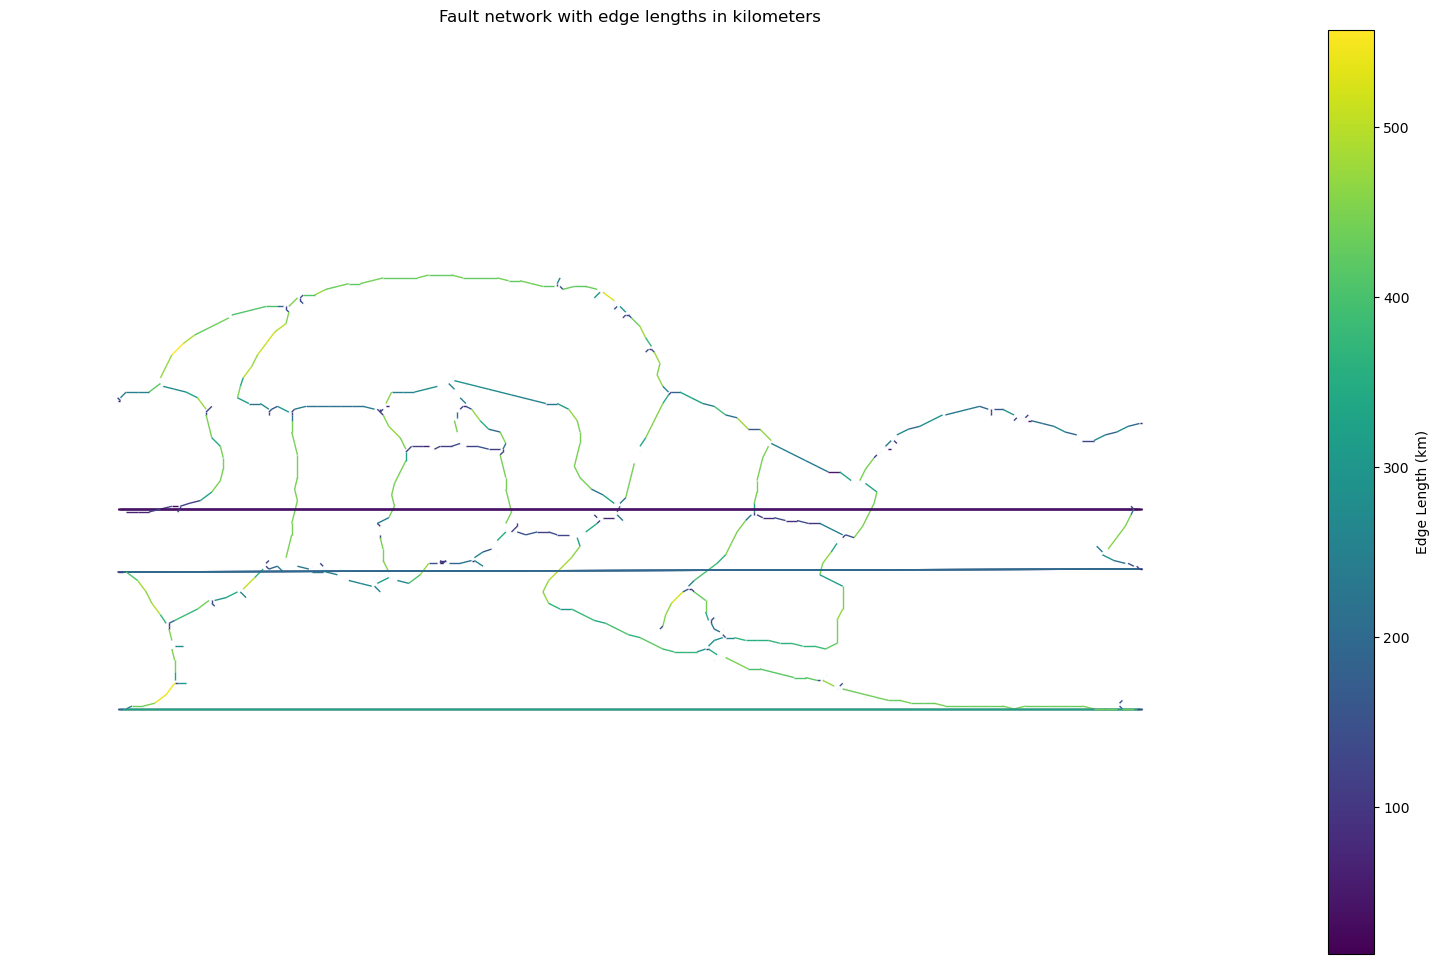

Maximum edge length is 557.0820882761343 km for edge (190, 205)


Widget(value='<iframe src="http://localhost:51233/index.html?ui=P_0x2a75cd6f0_0&reconnect=auto" class="pyvista…

In [31]:
# Extract edge lengths
edge_lengths = np.array([G1.edges[edge]['length'] for edge in G1.edges])

# Normalize edge lengths for colormap
norm = mcolors.Normalize(vmin=edge_lengths.min(), vmax=edge_lengths.max())
cmap = cm.viridis

# Generate colors based on lengths
edge_colors = [cmap(norm(length)) for length in edge_lengths]

# Draw the graph
fig, ax = plt.subplots(figsize=(20, 12))

ax.set_title('Fault network with edge lengths in kilometers')
nx.draw(G1, 
        pos=nx.get_node_attributes(G1, 'pos'),
        edge_color=edge_colors, 
        node_size=0.001,
        ax=ax,
        with_labels=False,
        edge_cmap=cmap,
        edge_vmin=edge_lengths.min(),
        edge_vmax=edge_lengths.max())
ax.axis('equal')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Length (km)')

plt.show()

# Print the maximum length and the corresponding edge
print(f"Maximum edge length is {max_length} km for edge {max_length_edge}")


def create_line_with_length(edge, cartesian_positions, edge_length):
    start, end = cartesian_positions[edge[0]], cartesian_positions[edge[1]]
    line = pv.Line(start, end)
    line['length'] = edge_length
    return line

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter with colors based on their strain rate
points = np.array([cartesian_positions[node] for node in G1.nodes])
point_cloud = pv.PolyData(points)
point_cloud['strain_rate'] = np.array([G1.nodes[node]['strain_rate'] for node in G1.nodes])
plotter.add_mesh(point_cloud, scalars='strain_rate', render_points_as_spheres=True, point_size=10, cmap='viridis')

# Parallelize the creation of lines for edges, including the length as scalar data
lines = Parallel(n_jobs=num_cores)(
    delayed(create_line_with_length)(edge, cartesian_positions, G1.edges[edge]['length']) for edge in G1.edges
)

# Combine all lines into a single MultiBlock and add them to the plotter
multi_line = pv.MultiBlock(lines)
plotter.add_mesh(multi_line, scalars='length', cmap='inferno', line_width=3.0)

# # Add a scalar bar
# plotter.add_scalar_bar(title="Edge Length (km)", n_labels=5, width=0.08, height=0.6, vertical=True, fmt="%.2f")

# Show the plot
plotter.show()


Awesome! That's it. You've extracted your first fault network. In the next tutorial, we will learn how to compute and visualize fault strikes:
https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb 

In [32]:
# Function to calculate the strike of an edge on a sphere
def calculate_strike(pos1, pos2):
    # Convert positions from Cartesian to spherical coordinates
    lat1 = np.degrees(np.arcsin(pos1[2] / 6371000))
    lon1 = np.degrees(np.arctan2(pos1[1], pos1[0]))
    lat2 = np.degrees(np.arcsin(pos2[2] / 6371000))
    lon2 = np.degrees(np.arctan2(pos2[1], pos2[0]))

    # Calculate the strike angle
    d_lon = lon2 - lon1
    d_lat = lat2 - lat1
    angle_rad = math.atan2(d_lon, d_lat)
    angle_deg = math.degrees(angle_rad)

    # Normalize the strike to be within [0, 360) degrees
    strike = angle_deg if angle_deg >= 0 else angle_deg + 360

    # Normalize the strike to be within [0, 180) degrees with 0 degrees meaning north
    if strike > 180:
        strike -= 180

    return strike

# Calculate the strike for each edge
strikes = []
for edge in G1.edges:
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    strike = calculate_strike(pos1, pos2)
    strikes.append(strike)
    G1.edges[edge]['strike'] = strike

# Normalize strike values for colormap
norm = plt.Normalize(vmin=min(strikes), vmax=max(strikes))
cmap = plt.cm.viridis

# Generate colors based on strikes
edge_colors = [cmap(norm(strike)) for strike in strikes]

# Create a PyVista plotter
plotter = pv.Plotter()

# Add a sphere to represent the Earth
sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

# Add nodes to the plotter
points = np.array([cartesian_positions[node] for node in G1.nodes])
point_cloud = pv.PolyData(points)
plotter.add_mesh(point_cloud, color='red', point_size=0.1, render_points_as_spheres=True)

# Add edges to the plotter with colors based on their strikes
for i, edge in enumerate(G1.edges):
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    line = pv.Line(pos1, pos2)
    plotter.add_mesh(line, color=edge_colors[i], line_width=5.0)

# Add a scalar bar for strikes
dummy_scalar_array = np.linspace(min(strikes), max(strikes), len(G1.edges))
dummy_points = np.random.rand(len(dummy_scalar_array), 3)  # Dummy points just for the scalar bar
plotter.add_mesh(pv.PolyData(dummy_points), scalars=dummy_scalar_array, cmap='viridis', show_scalar_bar=True)

# Show the plot
plotter.show()

# Print the maximum and minimum strike and the corresponding edge
max_strike = max(strikes)
max_strike_edge = list(G1.edges)[np.argmax(strikes)]
print(f"Maximum strike is {max_strike} degrees for edge {max_strike_edge}")
min_strike = min(strikes)
min_strike_edge = list(G1.edges)[np.argmin(strikes)]
print(f"Minimum strike is {min_strike} degrees for edge {min_strike_edge}")


Widget(value='<iframe src="http://localhost:51233/index.html?ui=P_0x15fcee320_1&reconnect=auto" class="pyvista…

Maximum strike is 180.0 degrees for edge (71, 82)
Minimum strike is 1.1368683772161603e-13 degrees for edge (805, 845)


In [33]:
#write plate boundaries
with open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries.p','wb') as p:
    pickle.dump(G1,p)

In [34]:
# reload G1 as G
# G = pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries.p', 'rb'))   
#
G=G1       

In [35]:


# Check if the graph is directed or undirected
if nx.is_directed(G):
    # For directed graphs, use strongly connected components
    num_components = nx.number_strongly_connected_components(G)
    components = list(nx.strongly_connected_components(G))
else:
    # For undirected graphs, use connected components
    num_components = nx.number_connected_components(G)
    components = list(nx.connected_components(G))

print(f"Number of connected components: {num_components}")


Number of connected components: 135


In [36]:



def plot_edge_attribute_3d(G, attribute):
    # Calculate the attribute values for each edge
    attributes = np.array([G.edges[edge][attribute] for edge in G.edges])

    # Normalize attribute values for colormap
    norm = plt.Normalize(vmin=attributes.min(), vmax=attributes.max())
    cmap = plt.cm.viridis

    # Generate colors based on attributes
    edge_colors = [cmap(norm(attr)) for attr in attributes]

    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add a sphere to represent the Earth
    sphere = pv.Sphere(radius=6371000, theta_resolution=360, phi_resolution=180)
    plotter.add_mesh(sphere, color='white', opacity=0.6, style='wireframe')

    # Add nodes to the plotter
    points = np.array([cartesian_positions[node] for node in G.nodes])
    point_cloud = pv.PolyData(points)
    plotter.add_mesh(point_cloud, color='red', point_size=0.1, render_points_as_spheres=True)

    # Parallelize the creation of lines for edges
    lines = Parallel(n_jobs=num_cores)(
        delayed(create_line)(edge, cartesian_positions) for edge in G.edges
    )

    # Add the lines to the plotter with corresponding colors
    for i, line in enumerate(lines):
        plotter.add_mesh(line, color=edge_colors[i], line_width=5.0)

    # Add a scalar bar for attributes
    dummy_scalar_array = np.linspace(attributes.min(), attributes.max(), len(G.edges))
    dummy_points = np.random.rand(len(dummy_scalar_array), 3)  # Dummy points just for the scalar bar
    plotter.add_mesh(pv.PolyData(dummy_points), scalars=dummy_scalar_array, cmap='viridis', show_scalar_bar=True)

    # Show the plot
    plotter.show()

# Example usage
plot_edge_attribute_3d(G, 'strike')

Widget(value='<iframe src="http://localhost:51233/index.html?ui=P_0x2de43a1d0_2&reconnect=auto" class="pyvista…

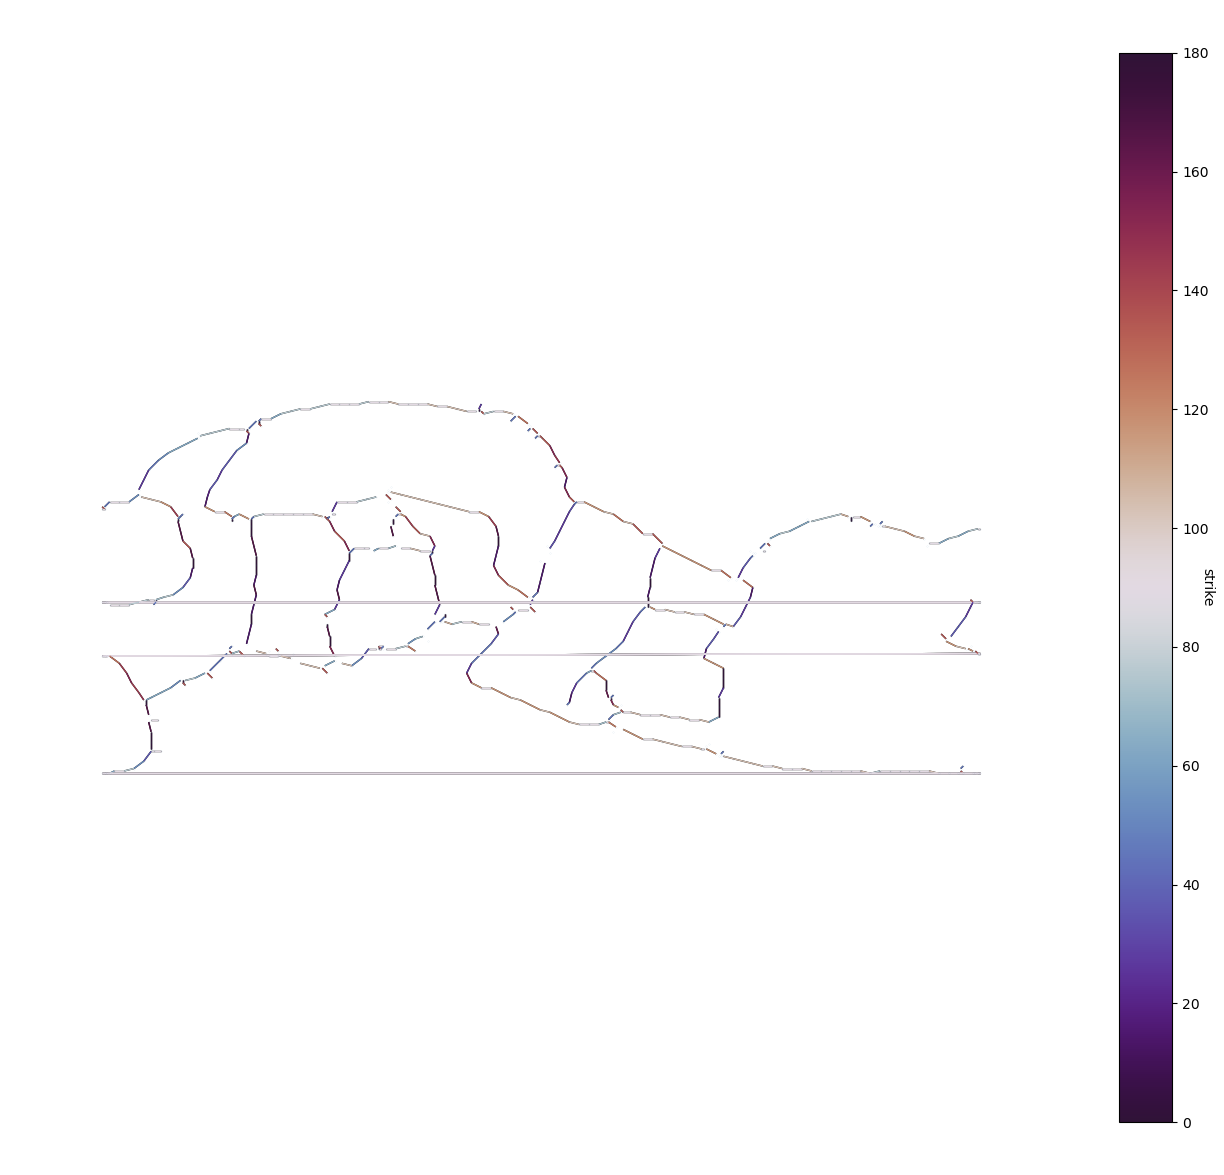

In [37]:
def plot_edge_attribute(G, attribute, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    pos = nx.get_node_attributes(G, 'pos')
    edges = np.array([G.edges[edge][attribute] for edge in G.edges])

    cmap = plt.cm.twilight_shifted
    # norm = plt.Normalize(vmin=compute_edge_values(G, attribute, 'min'), vmax=compute_edge_values(G, attribute, 'max'))
    norm = plt.Normalize(vmin=edges.min(), vmax=edges.max())

    nx.draw(G, pos=pos, node_size=0.001, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, edge_color=edges, edge_cmap=cmap, edge_vmin=norm.vmin, edge_vmax=norm.vmax, ax=ax)
    ax.axis('equal')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=
    ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(attribute, rotation=270)

# Example usage
fig, ax = plt.subplots(figsize=(15, 15))
plot_edge_attribute(G, 'strike', ax=ax)
plt.show()

[75.96375653207346, 90.0, 90.0, 104.03624346792641, 90.0, 75.96375653207338, 90.0, 90.0, 90.0, 90.0, 90.0, 104.03624346792667, 26.565051177078004, 75.96375653207372, 90.0, 104.03624346792627, 90.0, 75.96375653207315, 104.03624346792684, 180.0, 75.96375653207409, 90.0, 134.99999999999866, 90.0, 75.96375653207411, 104.03624346792591, 63.434948822921854, 45.0, 126.86989764584403, 45.0000000000004, 90.0, 44.999999999999716, 180.0, 134.9999999999996, 75.96375653207389, 90.0, 90.0, 180.0, 45.00000000000085, 134.9999999999998, 75.96375653207332, 135.0, 75.96375653207352, 14.036243467926681, 90.0, 44.9999999999998, 135.0000000000002, 63.434948822922166, 134.9999999999999, 63.43494882292208, 53.13010235415601, 153.4349488229224, 63.43494882292194, 36.86989764584388, 53.130102354155895, 146.3099324740195, 45.0, 36.86989764584402, 90.0, 45.00000000000159, 135.00000000000085, 153.43494882292202, 26.565051177078004, 26.565051177078004, 14.036243467926454, 26.565051177077947, 36.86989764584396, 153.

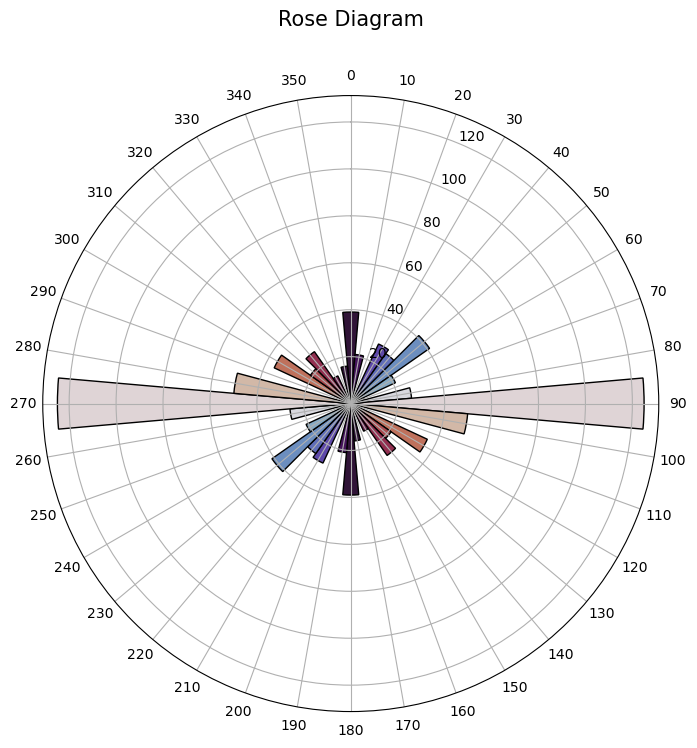

In [38]:

# Okay, the edges have very discrete strikes (0, 45, 90 degrees), because they were extracted from a regular array. This becomes even more evident when we plot the Rose diagram (a polar histogram of the strikes):

# %%
def plot_rose(strikes, lengths=[], ax=[]):    
    
    if lengths ==[]:
        lengths = np.ones_like(np.array(strikes))

    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, weights = lengths)           
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    cmap = plt.cm.twilight_shifted(np.concatenate((np.linspace(0, 1, 18), np.linspace(0, 1, 18)), axis=0))
     
    if ax==[]:
        fig = plt.figure(figsize=(8,8))
            
        ax = fig.add_subplot(111, projection='polar')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color=cmap, edgecolor='k')
    
    #    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title('Rose Diagram', y=1.10, fontsize=15)
    
    # fig.tight_layout()


# %%
strikes = [G.edges[edge]['strike'] for edge in G.edges]
print(strikes)
plot_rose(strikes)


In [39]:

# %% [markdown]
# Okay, that's not really what we want. We want the strikes of the faults, not the edges. So let's calculate those:

# I guess it is better to plot all strikes and lengths at once using extend since we only have a network of all connected plate boundary in this model
# in the case where many plate boumdaries appears we could cc>1 we could use append instead and pick the mean
# Calculate mean strikes for faults (connected components)
fault_strikes = []
fault_lengths = []
count = 0
for cc in nx.connected_components(G):
    count=+1
    edges = G.edges(cc)
    edge_strikes = [G.edges[edge]['strike'] for edge in edges]
    edge_lengths = [G.edges[edge]['length'] for edge in edges]
    # fault_strikes.append(np.mean(edge_strikes))
    # fault_lengths.append(np.mean(edge_lengths))
    fault_strikes.extend(edge_strikes)
    fault_lengths.extend(edge_lengths)
    print(count)

fault_strikes_float = [float(item) for item in fault_strikes]

fault_lengths_float = [float(item) for item in fault_lengths]




1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [40]:
print(fault_strikes_float)
print(fault_lengths_float)

[75.96375653207346, 90.0, 90.0, 104.03624346792641, 90.0, 75.96375653207338, 90.0, 90.0, 90.0, 90.0, 90.0, 104.03624346792667, 75.96375653207372, 90.0, 104.03624346792627, 90.0, 75.96375653207315, 104.03624346792684, 75.96375653207409, 90.0, 63.434948822921854, 45.0000000000004, 90.0, 180.0, 134.9999999999996, 26.565051177078004, 180.0, 104.03624346792591, 134.99999999999866, 90.0, 75.96375653207411, 45.0, 126.86989764584403, 44.999999999999716, 90.0, 75.96375653207332, 75.96375653207389, 75.96375653207352, 90.0, 36.86989764584388, 36.86989764584402, 180.0, 18.43494882292194, 14.03624346792651, 14.036243467926681, 53.13010235415601, 36.86989764584396, 135.0, 123.69006752597983, 116.56505117707805, 90.0, 26.565051177078004, 45.00000000000085, 134.9999999999998, 146.3099324740195, 153.4349488229224, 134.9999999999999, 90.0, 44.9999999999998, 135.0000000000002, 63.43494882292208, 63.434948822922166, 26.565051177077947, 63.43494882292194, 26.565051177078004, 45.0, 53.130102354155895, 153.4

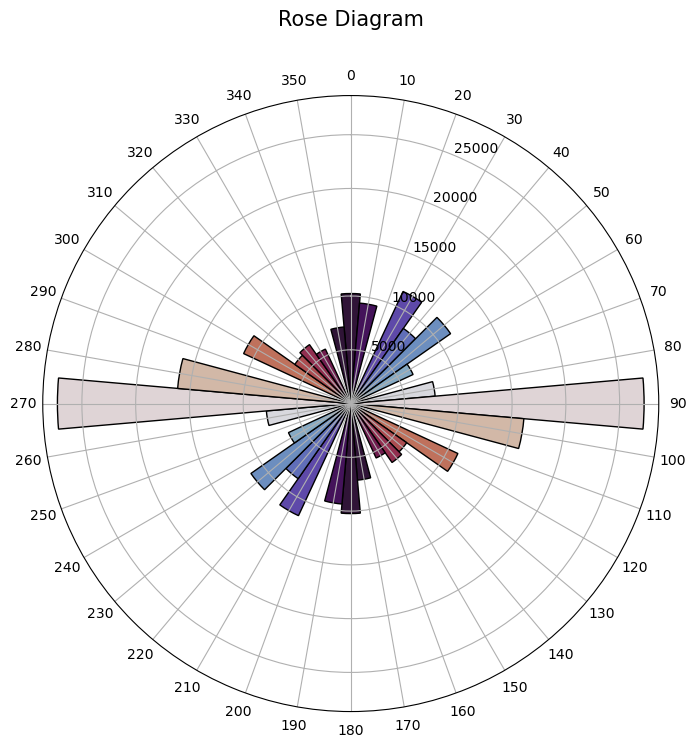

In [41]:
# Plot the Rose diagram
plot_rose(fault_strikes_float, fault_lengths_float)
plt.show()


In [42]:
import pickle
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

from fatbox.metrics import total_length, get_fault, get_fault_labels
from fatbox.plots import plot_components, plot_attribute, plot_faults

# Ensure inline plotting
%matplotlib inline

# List to store the loaded graphs
Gs = []

# Loop to load the graphs
for n in range(1, 3):  # Corrected the range to include one file
    Gs.append(pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries_' + str(n) + '.p', 'rb')))
    print(n)
# Define the plotting function
def f(time):
    fig, ax = plt.subplots(figsize=(16, 4))
    plot_components(Gs[time-1], node_size=1, ax=ax)  # Adjusted index to match slider range
    # plt.xlim([1000, 3500])
    # plt.ylim([600, 0])
    plt.show()
# print(len(Gs))
# Create interactive plot with a correct slider range
interactive_plot = interactive(f, time=widgets.IntSlider(min=1, max=len(Gs), step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot


1
2


interactive(children=(IntSlider(value=1, description='time', layout=Layout(width='900px'), max=2, min=1), Outp…

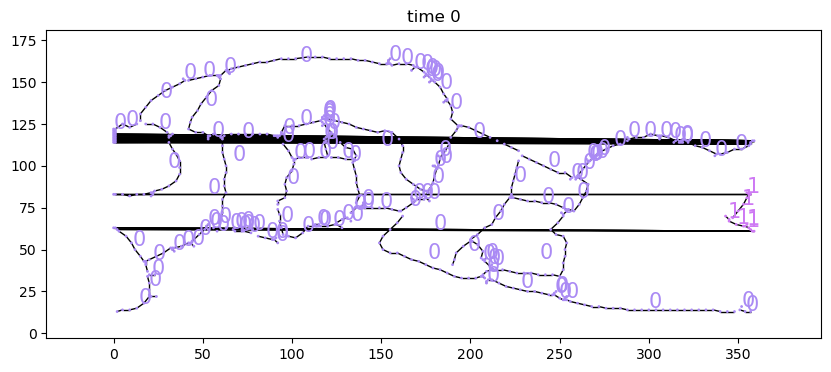

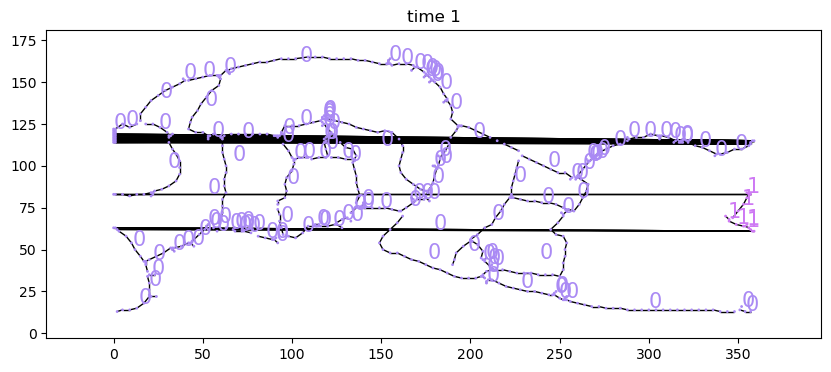

In [43]:
G_0 = Gs[0]
G_1 = Gs[1]

fig, ax = plt.subplots(figsize=(10, 4))
plot_components(G_0, node_size=1, ax=ax)
ax.set_title('time 0')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
plot_components(G_1, node_size=1, ax=ax)
ax.set_title('time 1')
plt.show()

In [44]:
# This only count the number of connected fault network not the number of fault
# # Add fault attribute to nodes
# for node in G_0.nodes():
#     G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

# for node in G_1.nodes():
#     G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

# # Print the first node to check
# print(list(G_0.nodes(data=True))[0])

##This count and assign the total number of fault
def assign_fault_labels(G):
    # Iterate over each connected component and assign a unique fault label
    for i, component in enumerate(nx.connected_components(G)):
        for node in component:
            G.nodes[node]['fault'] = i  # Assign the component index as the fault label

# Apply this to your graphs
assign_fault_labels(G_0)
assign_fault_labels(G_1)

# Function to count the number of unique faults
def count_faults(G):
    fault_labels = set(nx.get_node_attributes(G, 'fault').values())
    return len(fault_labels)

# Example usage for G_0 and G_1
num_faults_G0 = count_faults(G_0)
num_faults_G1 = count_faults(G_1)

print(f"Number of faults in G_0: {num_faults_G0}")
print(f"Number of faults in G_1: {num_faults_G1}")

Number of faults in G_0: 136
Number of faults in G_1: 136


In [45]:
# def get_nodes(G):
#     labels = get_fault_labels(G)
#     point_set=[]
#     for label in labels:            
#         G_fault = get_fault(G, label)
#         points = []
#         for node in G_fault:
#             points.append(G_fault.nodes[node]['pos'])
#         point_set.append(points)
#     return point_set


# def compute_similarity(set_A, set_B):
#       distances = np.zeros((len(set_A), len(set_B)))
#       for n, pt_0 in enumerate(set_A):
#           for m, pt_1 in enumerate(set_B):
#               distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
#       return np.mean(np.min(distances, axis=1))

 
# def correlation_slow(G_0, G_1, R):
#     # A function which labels the faults in G_1 according to G_0 using the 
#     # minimum radius R
    
    
#     # Get labels and nodes
#     fault_labels_0 = get_fault_labels(G_0)
#     fault_labels_1 = get_fault_labels(G_1)
    
#     nodes_0 = get_nodes(G_0)
#     nodes_1 = get_nodes(G_1) 


#     # Compute similarities    
#     smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
#     smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))    
    
    
#     for n in tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
#         for m in range(len(fault_labels_1)):
#             smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
#             smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])
            
            
#     # Determine correlations
#     correlations = set()
#     for n in tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
#         for m in range(len(fault_labels_1)):
#             if smf[n,m] < R:
#                 correlations.add((fault_labels_0[n], fault_labels_1[m]))
#             if smb[m,n] < R:
#                 correlations.add((fault_labels_0[n], fault_labels_1[m]))                 

#     return correlations, smf, smb


In [46]:
##This was re-written so it compares similarity between fault and not between network
def get_nodes(G):
    # Get unique fault labels directly from the node attributes
    fault_labels = set(nx.get_node_attributes(G, 'fault').values())
    point_set = []
    
    for label in fault_labels:            
        # Filter nodes belonging to the current fault label
        nodes_in_fault = [node for node in G.nodes if G.nodes[node]['fault'] == label]
        points = [G.nodes[node]['pos'] for node in nodes_in_fault]
        point_set.append(points)
    
    return point_set

def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))

def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the minimum radius R
    
    # Get nodes grouped by faults
    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1)

    # Get the number of faults
    num_faults_0 = len(nodes_0)
    num_faults_1 = len(nodes_1)

    # Compute similarities    
    smf = np.zeros((num_faults_0, num_faults_1))
    smb = np.zeros((num_faults_1, num_faults_0))
    
    for n in tqdm(range(num_faults_0), desc='   Compute similarities'):
        for m in range(num_faults_1):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])
    
    # Determine correlations
    correlations = set()
    for n in tqdm(range(num_faults_0), desc='   Find correlations'):
        for m in range(num_faults_1):
            if smf[n,m] < R:
                correlations.add((n, m))
            if smb[m,n] < R:
                correlations.add((n, m))
    
    return correlations, smf, smb


In [47]:
R = 5
correlations, smf, smb = correlation_slow(G_0, G_1, R=R)

   Find correlations: 100%|██████████| 136/136 [00:00<00:00, 34126.55it/s]


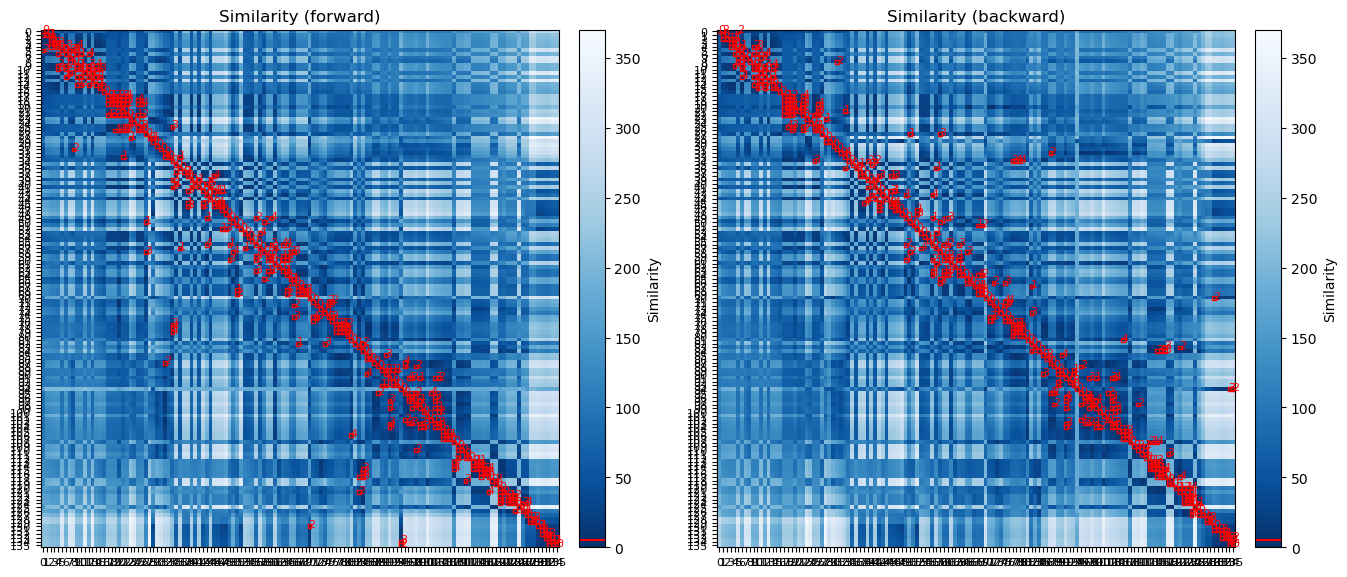

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[0].set_title('Similarity (forward)')
im_0 = axs[0].imshow(smf, cmap='Blues_r')
axs[0].set_yticks(range(smf.shape[0]))
axs[0].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[0].set_xticks(range(smf.shape[1]))
axs[0].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_0, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smf.shape[0]):
    for y in range(smf.shape[1]):
        if smf[x,y] < R:
            axs[0].text(y-0.25,x+0.25, int(smf[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[0].add_patch(rect)
        else:
            pass


axs[1].set_title('Similarity (backward)')
im_1 = axs[1].imshow(np.transpose(smb), cmap='Blues_r')
axs[1].set_yticks(range(smf.shape[0]))
axs[1].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[1].set_xticks(range(smf.shape[1]))
axs[1].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_1, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smb.shape[0]):
    for y in range(smb.shape[1]):
        if smb[x,y] < R:
            axs[1].text(x-0.25,y+0.25, int(smb[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[1].add_patch(rect)
        else:
            pass

plt.show()

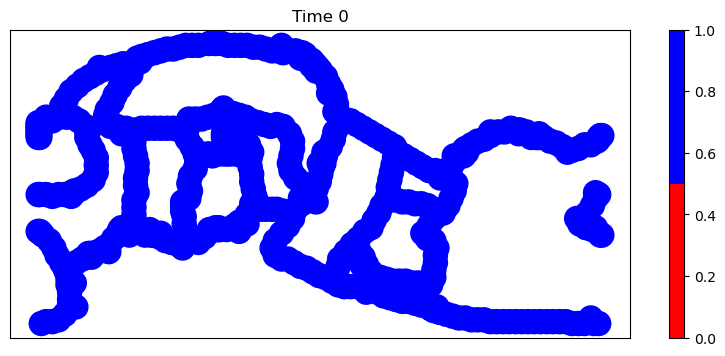

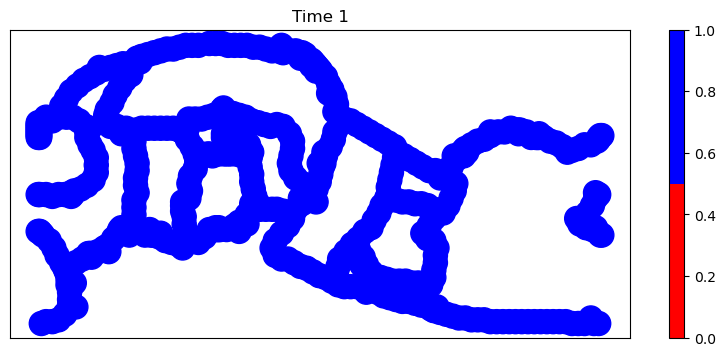

In [49]:
import matplotlib.colors as mcolors  # Correct import for colors

# Define the colormap for correlation
cmap_rb = mcolors.ListedColormap(['red', 'blue'])  # Blue for correlated, Red for anticorrelated

# Function to plot an attribute with a colormap
def plot_attribute(G, attribute, cmap='viridis', vmin=None, vmax=None, ax=None, **kwargs):
    pos = nx.get_node_attributes(G, 'pos')
    values = np.array([G.nodes[node][attribute] for node in G.nodes()])
    
    if vmin is None:
        vmin = values.min()
    if vmax is None:
        vmax = values.max()
    
    if ax is None:
        ax = plt.gca()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_color=values, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, **kwargs)
    
    return nodes

# Assign correlation status to nodes in G_0
for node in G_0:
    if G_0.nodes[node]['fault'] in [corr[0] for corr in correlations]:  # Check if fault is correlated
        G_0.nodes[node]['correlated'] = 1  # Correlated
    else:
        G_0.nodes[node]['correlated'] = 0  # Anticorrelated

# Assign correlation status to nodes in G_1
for node in G_1:
    if G_1.nodes[node]['fault'] in [corr[1] for corr in correlations]:  # Check if fault is correlated
        G_1.nodes[node]['correlated'] = 1  # Correlated
    else:
        G_1.nodes[node]['correlated'] = 0  # Anticorrelated

# Plot for G_0
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Time 0')
nodes = plot_attribute(G_0, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
fig.colorbar(nodes, ax=ax)
plt.show()

# Plot for G_1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Time 1')
nodes = plot_attribute(G_1, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
fig.colorbar(nodes, ax=ax)
plt.show()


In [50]:
# Assuming G_0 is the graph you want to inspect

# Print all graph-level attributes
print("Graph attributes:")
for attr, value in G_0.graph.items():
    print(f"{attr}: {value}")

# Print all node attributes
print("\nNode attributes:")
for node in G_0.nodes(data=True):
    print(f"Node {node[0]}: {node[1]}")

# Print all edge attributes
print("\nEdge attributes:")
for edge in G_0.edges(data=True):
    print(f"Edge {edge[0]}-{edge[1]}: {edge[2]}")

# Additionally, to get specific attributes
print("\nSpecific node attributes:")
for node, attr_dict in G_0.nodes(data=True):
    for attr, value in attr_dict.items():
        print(f"Node {node} has {attr}: {value}")

print("\nSpecific edge attributes:")
for (u, v, attr_dict) in G_0.edges(data=True):
    for attr, value in attr_dict.items():
        print(f"Edge {u}-{v} has {attr}: {value}")

# Iterate over all edges and check for 'strike' attribute
for edge in G_0.edges(data=True):
    u, v, attr = edge
    if 'strike' in attr:
        print(f"Edge {u}-{v} has 'strike' attribute with value: {attr['strike']}")
    else:
        print(f"Edge {u}-{v} does not have 'strike' attribute.")

# Check if the 'strike' attribute is present for all edges
edge_strikes_present = all('strike' in G_0.edges[edge] for edge in G_0.edges)
print("All edges have 'strike' attribute:", edge_strikes_present)


Graph attributes:

Node attributes:
Node 3: {'pos': (np.int64(109), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.931945337557593), 'fault': 0, 'correlated': 1}
Node 7: {'pos': (np.int64(113), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.815595626831055), 'fault': 0, 'correlated': 1}
Node 11: {'pos': (np.int64(117), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.80673838260888), 'fault': 0, 'correlated': 1}
Node 16: {'pos': (np.int64(94), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-16.316849841597495), 'fault': 0, 'correlated': 1}
Node 20: {'pos': (np.int64(98), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-14.940212061113506), 'fault': 0, 'correlated': 1}
Node 24: {'pos': (np.int64(102), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-14.588200786536389), 'fault': 0, 'correlated': 1}
Node 28: {'pos': (np.int64(121), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-13.943551385144442), 'fau

In [51]:
#to modify later
G= G_0
# Extract fault labels from all nodes
fault_labels = nx.get_node_attributes(G, 'fault')

# Find the maximum fault label
max_fault_label = max(fault_labels.values())

print(f"The maximum fault label is: {max_fault_label}")

The maximum fault label is: 135


Unique fault labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135]
Counts for each fault label: [25  4  5  2  2  2  1  5 14  2  2  1  1  9  2  5  7  1  1  1 21  7  1  4
  5  3  1 16  1 20 16  5 22  2 17  5  7  3  3  2  1  1  3  5  3  1  1  6
  5  4  1  8  1  4  3  4  2  1  2  1  2  9  8  1  3  2  8 10  1  1  8  2
  2  8  9  2  4  4  2  1  7  5  1 22 22  3  1  1  2  4  5  2  5  1  6  3
  2  1  3  1  1  6  1  2  2  3  1  2  9  3  2  8  3  2  1  2  1  3  2  4
 11  2  1  1  3  8  3 25  1  3  

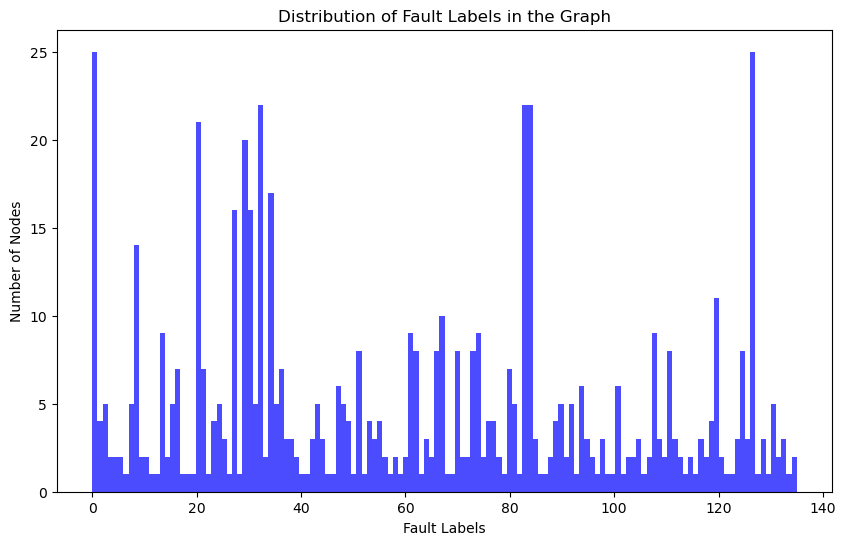

In [52]:
# Extract fault labels
fault_labels = np.array(list(nx.get_node_attributes(G, 'fault').values()))

# Print unique fault labels and their count
unique_faults, counts = np.unique(fault_labels, return_counts=True)
print(f"Unique fault labels: {unique_faults}")
print(f"Counts for each fault label: {counts}")

# Visualize the distribution of fault labels
plt.figure(figsize=(10, 6))
plt.hist(fault_labels, bins=len(unique_faults), color='blue', alpha=0.7)
plt.xlabel('Fault Labels')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Fault Labels in the Graph')
plt.show()

In [53]:
from scipy.interpolate import griddata
# from fatbox.metrics import total_length
# from fatbox.plots import plot_faults, plot_components, plot_attribute
import seaborn as sns
from matplotlib.colors import Normalize
# G = pickle.load(open('/Users/ponsm/Desktop/software/fatbox/fatbox_Pons/plate_bourndaries_2.p', 'rb'))

# G = G_0

# Assuming longitude, latitude, and surface_velocity are defined
surface_velocity = data.point_data['surface_velocity']
print(surface_velocity)


[[ 6.9132322e-03  0.0000000e+00  5.0478582e-03]
 [ 7.0207254e-03 -1.9685831e-05  5.1557673e-03]
 [ 7.1282191e-03 -3.9371662e-05  5.2636759e-03]
 ...
 [-3.7437461e-03 -7.0203687e-03 -1.7438198e-02]
 [-3.7710969e-03 -6.9834050e-03 -1.7381093e-02]
 [-3.7984753e-03 -6.9464510e-03 -1.7324079e-02]]


In [54]:
# Print all graph-level attributes
print("Graph attributes:")
for attr, value in G.graph.items():
    print(f"{attr}: {value}")

# Print all node attributes
print("\nNode attributes:")
for node in G.nodes(data=True):
    print(f"Node {node[0]}: {node[1]}")

# Print all edge attributes
print("\nEdge attributes:")
for edge in G.edges(data=True):
    print(f"Edge {edge[0]}-{edge[1]}: {edge[2]}")

# Additionally, to get specific attributes
print("\nSpecific node attributes:")
for node, attr_dict in G.nodes(data=True):
    for attr, value in attr_dict.items():
        print(f"Node {node} has {attr}: {value}")

print("\nSpecific edge attributes:")
for (u, v, attr_dict) in G.edges(data=True):
    for attr, value in attr_dict.items():
        print(f"Edge {u}-{v} has {attr}: {value}")


# Iterate over all edges and check for 'strike' attribute
for edge in G.edges(data=True):
    u, v, attr = edge
    if 'strike' in attr:
        print(f"Edge {u}-{v} has 'strike' attribute with value: {attr['strike']}")
    else:
        print(f"Edge {u}-{v} does not have 'strike' attribute.")

# Check if the 'strike' attribute is present for the edges
edge_strikes_present = all('strike' in G.edges[edge] for edge in G.edges)
print("All edges have 'strike' attribute:", edge_strikes_present)


Graph attributes:

Node attributes:
Node 3: {'pos': (np.int64(109), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.931945337557593), 'fault': 0, 'correlated': 1}
Node 7: {'pos': (np.int64(113), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.815595626831055), 'fault': 0, 'correlated': 1}
Node 11: {'pos': (np.int64(117), np.int64(165)), 'component': 0, 'strain_rate': np.float64(-14.80673838260888), 'fault': 0, 'correlated': 1}
Node 16: {'pos': (np.int64(94), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-16.316849841597495), 'fault': 0, 'correlated': 1}
Node 20: {'pos': (np.int64(98), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-14.940212061113506), 'fault': 0, 'correlated': 1}
Node 24: {'pos': (np.int64(102), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-14.588200786536389), 'fault': 0, 'correlated': 1}
Node 28: {'pos': (np.int64(121), np.int64(164)), 'component': 0, 'strain_rate': np.float64(-13.943551385144442), 'fau

In [55]:
# Ensure the surface_velocity is separated into components
surface_velocity = data.point_data['surface_velocity']
v_x = surface_velocity[:, 0]
v_y = surface_velocity[:, 1]
v_z = surface_velocity[:, 2]

# Calculate the velocity magnitude
velocity_magnitude = np.sqrt(v_x**2 + v_y**2 + v_z**2)
data.point_data['velocity_magnitude'] = velocity_magnitude
data.point_data['v_x'] = v_x
data.point_data['v_y'] = v_y
data.point_data['v_z'] = v_z

# # Interpolate the v_z component
# v_z_interp = griddata((longitude, latitude), v_z, (lon_grid, lat_grid), method='linear')

# # Handle missing values by nearest interpolation for v_z component
# v_z_interp = np.where(np.isnan(v_z_interp), 
#                       griddata((longitude, latitude), v_z, (lon_grid, lat_grid), method='nearest'), 
#                       v_z_interp)


# Calculate the strike for each edge
# strikes = []
# for edge in G.edges:
#     pos1 = cartesian_positions[edge[0]]
#     pos2 = cartesian_positions[edge[1]]
#     strike = calculate_strike(pos1, pos2)
#     strikes.append(strike)
#     G.edges[edge]['strike'] = strike

# Retrieve strike values from edges

strikes = np.array([G.edges[edge]['strike'] for edge in G.edges])

geographic_positions = {}
cartesian_positions = {}
points = []

for node in G.nodes:
    lon, lat = G.nodes[node]['pos']
    # Transform the (col, row) coordinates to lat, lon assuming the image covers the entire globe
    lon = (lon / skeleton_cleaned_flipped.shape[1]) * 360 - 180
    lat = (lat / skeleton_cleaned_flipped.shape[0]) * 180 - 90

    geographic_positions[node] = (lon, lat)
    
    x, y, z = latlon_to_cartesian(lat, lon)
    points.append([x, y, z])
    cartesian_positions[node] = (x, y, z)

# Normalize strike values for colormap
norm = plt.Normalize(vmin=strikes.min(), vmax=strikes.max())
cmap = plt.cm.viridis

# Create a PyVista plotter
plotter = pv.Plotter()

# Add the surface velocity field
plotter.add_mesh(data, scalars='velocity_magnitude', cmap='inferno', clim=[-0.05, 0.05])

# Add nodes to the plotter
points = np.array([cartesian_positions[node] for node in G.nodes])
point_cloud = pv.PolyData(points)
plotter.add_mesh(point_cloud, color='red', point_size=0.1, render_points_as_spheres=True)

# Prepare all edges in one MultiBlock with corresponding strike values
lines = []
for i, edge in enumerate(G.edges):
    pos1 = cartesian_positions[edge[0]]
    pos2 = cartesian_positions[edge[1]]
    line = pv.Line(pos1, pos2)
    # Assign the strike value as a scalar
    line['strike'] = np.array([strikes[i], strikes[i]])
    lines.append(line)

# Combine all lines into a single MultiBlock
multi_line = pv.MultiBlock(lines)

# Add each block to the plotter
for block in multi_line:
    plotter.add_mesh(block, scalars='strike', cmap='viridis', line_width=5.0)

# Add a scalar bar for strikes
# plotter.add_scalar_bar(title="Strike", cmap='viridis', n_labels=5, width=0.08, height=0.6, vertical=True)

# Show the plot
plotter.show()


Widget(value='<iframe src="http://localhost:51233/index.html?ui=P_0x2cce36ce0_3&reconnect=auto" class="pyvista…

In [56]:
# ##Lets paralelised griddata
# # Function to perform griddata interpolation
# def interpolate_velocity(method):
#     return griddata((longitude, latitude), velocity_magnitude, (lon_grid, lat_grid), method=method)

# # Parallelize the interpolation steps
# v_mag_interp, v_mag_nearest = Parallel(n_jobs=num_cores)(
#     delayed(interpolate_velocity)(method) for method in ['linear', 'nearest']
# )

# # Handle missing values in the linear interpolation by filling with nearest interpolation
# v_mag_interp = np.where(np.isnan(v_mag_interp), v_mag_nearest, v_mag_interp)


In [71]:
# Function to perform griddata interpolation for a specific velocity component
def interpolate_velocity_component(velocity_component, method):
    return griddata((longitude, latitude), velocity_component, (lon_grid, lat_grid), method=method)

# Define the number of cores you want to use (use all available cores with -1)
num_cores = -1

# Parallelize the interpolation for each component and method
v_x_interp, v_x_nearest = Parallel(n_jobs=num_cores)(
    delayed(interpolate_velocity_component)(v_x, method) for method in ['linear', 'nearest']
)

v_y_interp, v_y_nearest = Parallel(n_jobs=num_cores)(
    delayed(interpolate_velocity_component)(v_y, method) for method in ['linear', 'nearest']
)

v_z_interp, v_z_nearest = Parallel(n_jobs=num_cores)(
    delayed(interpolate_velocity_component)(v_z, method) for method in ['linear', 'nearest']
)

# Handle missing values in the linear interpolation by filling with nearest interpolation
v_x_interp = np.where(np.isnan(v_x_interp), v_x_nearest, v_x_interp)
v_y_interp = np.where(np.isnan(v_y_interp), v_y_nearest, v_y_interp)
v_z_interp = np.where(np.isnan(v_z_interp), v_z_nearest, v_z_interp)

In [ ]:
##Lets paralelised griddata
# # Function to perform griddata interpolation
# def interpolate_velocity(method):
#     return griddata((longitude, latitude), velocity_magnitude, (lon_grid, lat_grid), method=method)

# # Parallelize the interpolation steps
# v_mag_interp, v_mag_nearest = Parallel(n_jobs=num_cores)(
#     delayed(interpolate_velocity)(method) for method in ['linear', 'nearest']
# )

# # Handle missing values in the linear interpolation by filling with nearest interpolation
# v_mag_interp = np.where(np.isnan(v_mag_interp), v_mag_nearest, v_mag_interp)


In [57]:

# # Plot the interpolated velocity magnitude
# fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# # Set the extent of the plot to match the grid boundaries
# lon_min, lon_max = lon_grid.min(), lon_grid.max()
# lat_min, lat_max = lat_grid.min(), lat_grid.max()

# # Plot the interpolated velocity magnitude on the map
# c_scheme = ax.imshow(v_mag_interp, extent=(lon_min, lon_max, lat_min, lat_max), 
#                      transform=ccrs.PlateCarree(), cmap='inferno', origin='lower')

# # Add coastlines for context (optional)
# ax.coastlines()

# # Add a colorbar to the plot
# cb = plt.colorbar(c_scheme, ax=ax, orientation='horizontal', pad=0.05)
# cb.set_label('Velocity Magnitude')

# # Set the title of the plot
# plt.title('Interpolated Velocity Magnitude')

# # Show the plot
# plt.show()

Node 3: Longitude = -71.00000000000001, Latitude = 75.0
Node 7: Longitude = -67.0, Latitude = 75.0
Node 11: Longitude = -63.0, Latitude = 75.0
Node 16: Longitude = -86.0, Latitude = 74.0
Node 20: Longitude = -82.00000000000001, Latitude = 74.0
Node 24: Longitude = -78.0, Latitude = 74.0
Node 28: Longitude = -58.999999999999986, Latitude = 74.0
Node 32: Longitude = -55.0, Latitude = 74.0
Node 36: Longitude = -51.0, Latitude = 74.0
Node 40: Longitude = -47.0, Latitude = 74.0
Node 42: Longitude = -25.0, Latitude = 74.0
Node 46: Longitude = -90.0, Latitude = 73.0
Node 51: Longitude = -43.0, Latitude = 73.0
Node 55: Longitude = -39.0, Latitude = 73.0
Node 56: Longitude = -26.0, Latitude = 73.0
Node 59: Longitude = -98.0, Latitude = 72.0
Node 63: Longitude = -94.0, Latitude = 72.0
Node 67: Longitude = -35.0, Latitude = 72.0
Node 71: Longitude = -26.0, Latitude = 72.0
Node 75: Longitude = -102.0, Latitude = 71.0
Node 77: Longitude = -31.0, Latitude = 71.0
Node 81: Longitude = -27.0, Latitude 

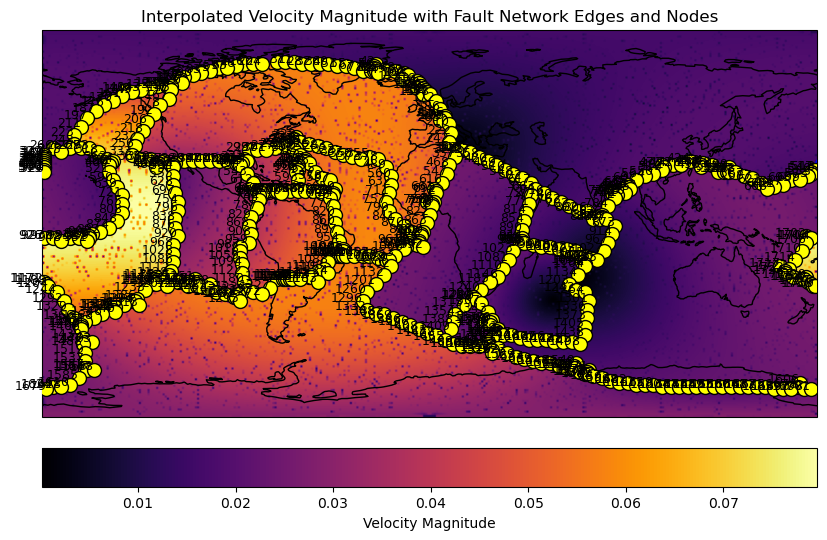

In [58]:

# Print the geographic positions to verify
for node, pos in geographic_positions.items():
    print(f"Node {node}: Longitude = {pos[0]}, Latitude = {pos[1]}")

# Plot the interpolated velocity magnitude
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the plot to match the grid boundaries
lon_min, lon_max = lon_grid.min(), lon_grid.max()
lat_min, lat_max = lat_grid.min(), lat_grid.max()

# Plot the interpolated velocity magnitude on the map
c_scheme = ax.imshow(v_mag_interp, extent=(lon_min, lon_max, lat_min, lat_max), 
                     transform=ccrs.PlateCarree(), cmap='inferno', origin='lower')

# Add coastlines for context
ax.coastlines()

# Add a colorbar to the plot
cb = plt.colorbar(c_scheme, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Velocity Magnitude')

# Overlay the edges of the graph on the plot
for edge in G.edges:
    pos1 = geographic_positions[edge[0]]
    pos2 = geographic_positions[edge[1]]
    ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], transform=ccrs.Geodetic(), 
            color='blue', linewidth=1.5)

# Overlay the nodes of the graph with larger size and different color
for node, pos in geographic_positions.items():
    ax.scatter(pos[0], pos[1], c='yellow', edgecolor='black', s=100, transform=ccrs.PlateCarree(), zorder=5)
    ax.text(pos[0], pos[1], str(node), fontsize=9, ha='right', transform=ccrs.PlateCarree(), zorder=6, color='black')

# Set the title of the plot
plt.title('Interpolated Velocity Magnitude with Fault Network Edges and Nodes')

# Show the plot
plt.show()

In [75]:
# print(np.min(lon_grid))
# positions = nx.get_node_attributes(G, 'pos')
# print(positions)

In [76]:
# # We can get each component as a scalar using 

# v_x_interp = griddata((longitude, latitude), v_x, (lon_grid, lat_grid), method='linear')

# v_y_interp = griddata((longitude, latitude), v_y, (lon_grid, lat_grid), method='linear')

# v_z_interp = griddata((longitude, latitude), v_z, (lon_grid, lat_grid), method='linear')

# # Fill missing values (NaNs) with nearest values
# v_x_interp = np.where(np.isnan(v_x_interp), 
#                       griddata((longitude, latitude), v_x, (lon_grid, lat_grid), method='nearest'), 
#                       v_x_interp)
# v_y_interp = np.where(np.isnan(v_y_interp), 
#                       griddata((longitude, latitude), v_y, (lon_grid, lat_grid), method='nearest'), 
#                       v_y_interp)
# v_z_interp = np.where(np.isnan(v_z_interp), 
#                       griddata((longitude, latitude), v_z, (lon_grid, lat_grid), method='nearest'), 
#                       v_z_interp)



## Extract velocities
Now we want to pick up the velocity left and right of each fault, but to do this we first need to calculate the direction of the fault:

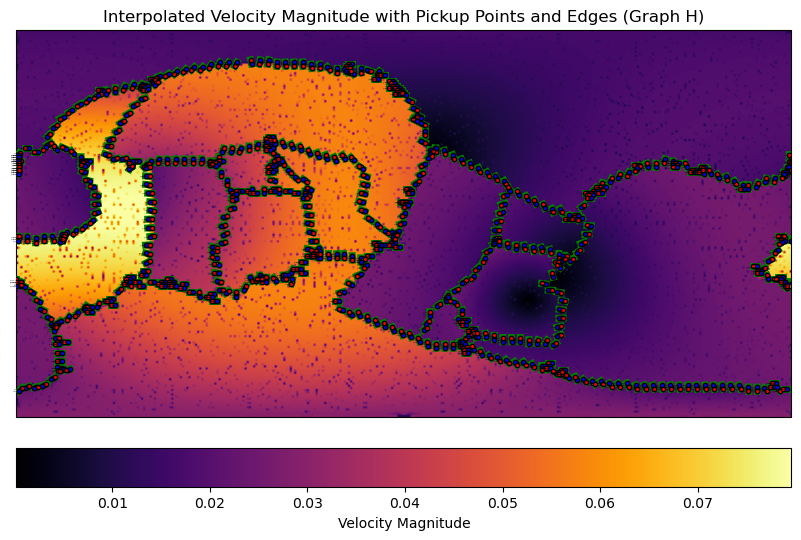

In [59]:

# Use the precalculated geographic positions
for node, pos in geographic_positions.items():
    G.nodes[node]['pos'] = pos

# Function to calculate direction vectors using geographic positions
def calculate_direction(G, cutoff, normalize=True):
    for node in G.nodes:
        length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
        keys = [key for key, value in length.items() if value == max(length.values())]

        if len(keys) > 2:
            node_0, node_1 = keys[:2]
        elif len(keys) == 2:
            node_0, node_1 = keys
        elif len(keys) == 1:
            node_0 = keys[0]
            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff-1)
            keys = [key for key, value in length.items() if value == max(length.values())]
            node_1 = keys[0]

        # Extract geographic positions
        pt_0 = geographic_positions[node_0]  # (lon, lat)
        pt_1 = geographic_positions[node_1]  # (lon, lat)

        # Convert lat/lon from degrees to radians
        lat1 = np.radians(pt_0[1])
        lon1 = np.radians(pt_0[0])
        lat2 = np.radians(pt_1[1])
        lon2 = np.radians(pt_1[0])

        # Calculate differences
        dlon = lon2 - lon1

        # Calculate the bearing
        x = np.sin(dlon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

        bearing = np.arctan2(x, y)  # Bearing in radians

        # Convert bearing to degrees and normalize
        bearing_degrees = np.degrees(bearing)
        bearing_degrees = (bearing_degrees + 360) % 360  # Normalize to 0-360 degrees

        # Optionally normalize to a unit vector
        if normalize:
            dx = np.cos(np.radians(bearing_degrees))
            dy = np.sin(np.radians(bearing_degrees))
        else:
            dx = x
            dy = y

        # Write to graph
        G.nodes[node]['dx'] = dx
        G.nodes[node]['dy'] = dy

    return G

# Function to calculate pickup points using geographic positions
def calculate_pickup_points(G, factor):
    H = nx.Graph()

    for node in G.nodes:
        lon, lat = geographic_positions[node]  # Current position of the node (longitude, latitude)

        dx = G.nodes[node]['dx']  # Direction vector dx
        dy = G.nodes[node]['dy']  # Direction vector dy

        # Scale the direction by the factor
        dx = factor * dx
        dy = factor * dy

        # Calculate the new positions
        lat_p = lat + dy
        lon_p = lon + dx

        lat_n = lat - dy
        lon_n = lon - dx

        # Ensure the latitude and longitude stay within valid bounds
        lat_p = np.clip(lat_p, -90, 90)
        lat_n = np.clip(lat_n, -90, 90)
        lon_p = (lon_p + 180) % 360 - 180
        lon_n = (lon_n + 180) % 360 - 180

        # Handle potential discontinuities near the poles
        if abs(lat_p) == 90:
            lon_p = lon  # Keep longitude unchanged at the poles
        if abs(lat_n) == 90:
            lon_n = lon  # Keep longitude unchanged at the poles

        # Create nodes and assign positions
        node_mid = (node, 0)
        H.add_node(node_mid)
        H.nodes[node_mid]['pos'] = (lon, lat)
        H.nodes[node_mid]['component'] = -1

        node_p = (node, 1)
        H.add_node(node_p)
        H.nodes[node_p]['pos'] = (lon_p, lat_p)
        H.nodes[node_p]['component'] = -2

        node_n = (node, 2)
        H.add_node(node_n)
        H.nodes[node_n]['pos'] = (lon_n, lat_n)
        H.nodes[node_n]['component'] = -3

        # Add an edge between the two pickup points
        H.add_edge(node_n, node_p)

    return H

# Example usage
G4 = calculate_direction(G, 3)
H = calculate_pickup_points(G4, 1)

# No need to correct latitude as positions are already in geographic coordinates.

# Function to prepare edge data
def plot_edge(edge):
    pos1 = H.nodes[edge[0]]['pos']
    pos2 = H.nodes[edge[1]]['pos']
    return ([pos1[0], pos2[0]], [pos1[1], pos2[1]])

# Function to prepare node data
def plot_node(node, pos):
    component = H.nodes[node]['component']
    color = 'yellow' if component == -1 else 'blue' if component == -2 else 'red'
    return (pos[0], pos[1], color, str(node))

# Prepare edge data in parallel
edge_lines = Parallel(n_jobs=num_cores)(delayed(plot_edge)(edge) for edge in H.edges)

# Prepare node data in parallel
node_data = Parallel(n_jobs=num_cores)(delayed(plot_node)(node, pos) for node, pos in H.nodes(data='pos'))

# Plot the interpolated velocity magnitude
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the plot to match the grid boundaries
lon_min, lon_max = lon_grid.min(), lon_grid.max()
lat_min, lat_max = lat_grid.min(), lat_grid.max()

# Plot the interpolated velocity magnitude on the map
c_scheme = ax.imshow(v_mag_interp, extent=(lon_min, lon_max, lat_min, lat_max), 
                     transform=ccrs.PlateCarree(), cmap='inferno', origin='lower')

# Add coastlines for context
# ax.coastlines()

# Add a colorbar to the plot
cb = plt.colorbar(c_scheme, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Velocity Magnitude')

# Plot edges
for x_coords, y_coords in edge_lines:
    ax.plot(x_coords, y_coords, transform=ccrs.Geodetic(), color='green', linewidth=5, zorder=3)

# Plot nodes
for x, y, color, label in node_data:
    ax.scatter(x, y, c=color, edgecolor='black', s=10, transform=ccrs.PlateCarree(), zorder=5)
    ax.text(x, y, label, fontsize=0, ha='right', transform=ccrs.PlateCarree(), zorder=6, color='black')

# Set the title of the plot
plt.title('Interpolated Velocity Magnitude with Pickup Points and Edges (Graph H)')

# Show the plot
plt.show()

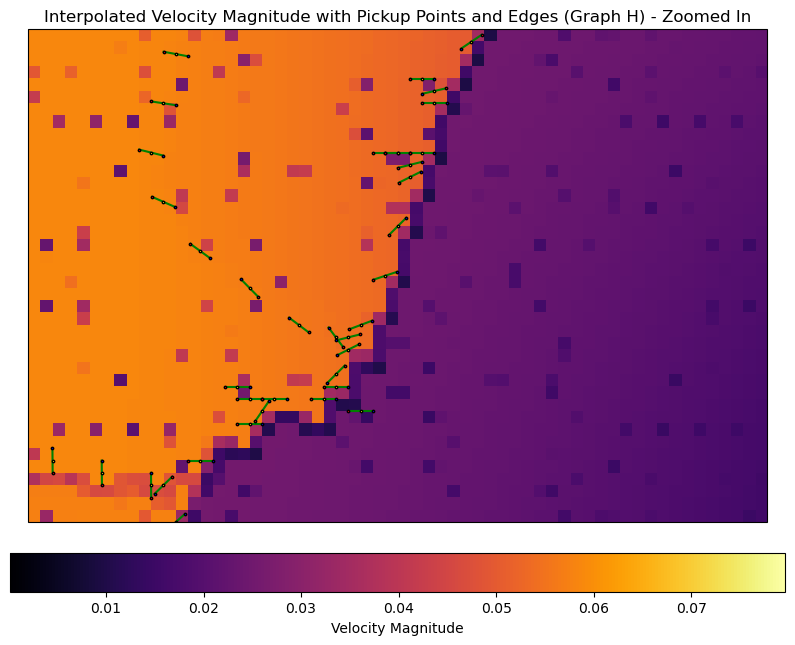

In [62]:

# Define the zoom boundaries
zoom_lon_min = -30  # Set your desired minimum longitude for zoom
zoom_lon_max = 30   # Set your desired maximum longitude for zoom
zoom_lat_min = -20  # Set your desired minimum latitude for zoom
zoom_lat_max = 20   # Set your desired maximum latitude for zoom

# Plot the interpolated velocity magnitude with zoom
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the plot to the zoom boundaries
ax.set_extent([zoom_lon_min, zoom_lon_max, zoom_lat_min, zoom_lat_max], crs=ccrs.PlateCarree())

# Plot the interpolated velocity magnitude on the map
c_scheme = ax.imshow(v_mag_interp, extent=(lon_min, lon_max, lat_min, lat_max), 
                     transform=ccrs.PlateCarree(), cmap='inferno', origin='lower')

# Add coastlines for context
# ax.coastlines()

# Add a colorbar to the plot
cb = plt.colorbar(c_scheme, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Velocity Magnitude')

# Plot edges
for x_coords, y_coords in edge_lines:
    ax.plot(x_coords, y_coords, transform=ccrs.Geodetic(), color='green', linewidth=1.5, zorder=3)

# Plot nodes
for x, y, color, label in node_data:
    ax.scatter(x, y, c=color, edgecolor='black', s=3, transform=ccrs.PlateCarree(), zorder=5)
    # ax.text(x, y, label, fontsize=3, ha='right', transform=ccrs.PlateCarree(), zorder=6, color='black')

# Set the title of the plot
plt.title('Interpolated Velocity Magnitude with Pickup Points and Edges (Graph H) - Zoomed In')

# Show the plot
plt.show()

In [72]:

def geographic_to_image_coordinates(lon, lat, x_max, y_max, lon_min, lon_max, lat_min, lat_max):
    """
    Converts geographic coordinates to image coordinates.
    """
    x_img = int((lon - lon_min) / (lon_max - lon_min) * x_max)
    y_img = int((lat_max - lat) / (lat_max - lat_min) * y_max)  # Flip latitude since images are top-down
    return x_img, y_img

# Function to extract attributes from the image and assign them to the graph nodes
def extract_attribute(G, image, name, lon_min, lon_max, lat_min, lat_max, channel=None):
    """
    Extracts attribute from image and assigns to graph nodes.
    
    Parameters:
    - G: Graph
    - image: 2D or 3D image array
    - name: Attribute name to assign
    - lon_min, lon_max, lat_min, lat_max: Geographic bounds of the image
    - channel: If the image is 3D, specify the channel to extract (e.g., 0 for R in RGB)
    """
    # Check image shape and handle accordingly
    print(f"Image shape: {image.shape}")  # Debugging line to print the shape of the image
    
    if len(image.shape) == 3:
        if channel is None:
            raise ValueError("Image has multiple channels; please specify the 'channel' parameter.")
        image = image[:, :, channel]
    elif len(image.shape) != 2:
        raise ValueError("Image must be either a 2D array or a 3D array with a specified channel.")
    
    (y_max, x_max) = image.shape  # y_max corresponds to the height (rows), x_max to width (columns)
    
    for node in G.nodes:
        lon, lat = G.nodes[node]['pos']
        x_img, y_img = geographic_to_image_coordinates(lon, lat, x_max, y_max, lon_min, lon_max, lat_min, lat_max)

        if x_img < 0 or y_img < 0 or x_img >= x_max or y_img >= y_max:
            G.nodes[node][name] = float('nan')  # Handle out-of-bounds indices
        else:
            G.nodes[node][name] = image[y_img, x_img]  # Access image using y (row) and x (column)
    
    return G

# Example usage:
lon_min, lon_max = lon_grid.min(), lon_grid.max()
lat_min, lat_max = lat_grid.min(), lat_grid.max()

# Assuming lon_min, lon_max, lat_min, lat_max are already defined

# Extract v_x, v_y, v_z attributes using the interpolated grids
H_extract = extract_attribute(H, v_x_interp, 'v_x', lon_min, lon_max, lat_min, lat_max)
H_extract = extract_attribute(H, v_y_interp, 'v_y', lon_min, lon_max, lat_min, lat_max)
H_extract = extract_attribute(H, v_z_interp, 'v_z', lon_min, lon_max, lat_min, lat_max)



Image shape: (180, 360)
Image shape: (180, 360)
Image shape: (180, 360)


In [73]:
def filter_pickup_points(G, H):    
    for node in G:
        # Check if the latitude of the pickup points is below 0 (Southern Hemisphere)
        if H.nodes[(node, 1)]['pos'][1] < 0 or H.nodes[(node, 2)]['pos'][1] < 0:
            # Set v_x, v_y, and v_z to 0 for the current node and its pickup points
            H.nodes[(node, 0)]['v_x'] = 0
            H.nodes[(node, 0)]['v_y'] = 0
            H.nodes[(node, 0)]['v_z'] = 0
    
            H.nodes[(node, 1)]['v_x'] = 0
            H.nodes[(node, 1)]['v_y'] = 0
            H.nodes[(node, 1)]['v_z'] = 0
    
            H.nodes[(node, 2)]['v_x'] = 0
            H.nodes[(node, 2)]['v_y'] = 0
            H.nodes[(node, 2)]['v_z'] = 0

    return H

# Apply the filtering
H_extract2 = filter_pickup_points(G, H_extract)


In [74]:
import math

def calculate_slip_rate(G, H, dim):
    for node in H.nodes:
        if node[1] == 0:  # Center point
            
            if dim == 2:
                # Check if either of the pickup points has zero velocity
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_rate_x'] = 0
                    G.nodes[node[0]]['slip_rate_z'] = 0
                    G.nodes[node[0]]['slip_rate'] = 0
                else:
                    G.nodes[node[0]]['slip_rate_x'] = abs(H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x'])
                    G.nodes[node[0]]['slip_rate_z'] = abs(H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z'])
                    G.nodes[node[0]]['slip_rate'] = math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + G.nodes[node[0]]['slip_rate_z']**2)
            
            elif dim == 3:
                # Check if either of the pickup points has zero velocity
                if (H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0 or 
                    H.nodes[(node[0], 1)]['v_y'] == 0 or H.nodes[(node[0], 2)]['v_y'] == 0 or
                    H.nodes[(node[0], 1)]['v_z'] == 0 or H.nodes[(node[0], 2)]['v_z'] == 0):
                    G.nodes[node[0]]['slip_rate_x'] = 0
                    G.nodes[node[0]]['slip_rate_y'] = 0
                    G.nodes[node[0]]['slip_rate_z'] = 0
                    G.nodes[node[0]]['slip_rate'] = 0
                else:
                    G.nodes[node[0]]['slip_rate_x'] = abs(H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x'])
                    G.nodes[node[0]]['slip_rate_y'] = abs(H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y'])
                    G.nodes[node[0]]['slip_rate_z'] = abs(H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z'])
                    G.nodes[node[0]]['slip_rate'] = math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + 
                                                              G.nodes[node[0]]['slip_rate_y']**2 + 
                                                              G.nodes[node[0]]['slip_rate_z']**2)
    
    return G

# Example usage:
G_slip = calculate_slip_rate(G, H_extract2, dim=3)  # For 2D slip rate calculation
# or
# G = calculate_slip_rate(G, H, dim=3)  # For 3D slip rate calculation


In [75]:
import math

def calculate_slip(G, H, dt, dim):
    if dim == 2:
        for node in H.nodes:
            if node[1] == 0:
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] = 0
                    G.nodes[node[0]]['slip_z'] = 0
                    G.nodes[node[0]]['slip'] = 0
                else:            
                    G.nodes[node[0]]['slip_x'] = abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x'])) * dt
                    G.nodes[node[0]]['slip_z'] = abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z'])) * dt
                    G.nodes[node[0]]['slip'] = math.sqrt(G.nodes[node[0]]['slip_x']**2 + G.nodes[node[0]]['slip_z']**2)
                                                            
    if dim == 3:
        for node in H.nodes:
            if node[1] == 0:
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] = 0
                    G.nodes[node[0]]['slip_y'] = 0
                    G.nodes[node[0]]['slip_z'] = 0
                    G.nodes[node[0]]['slip'] = 0
                else:            
                    G.nodes[node[0]]['slip_x'] = abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x'])) * dt
                    G.nodes[node[0]]['slip_y'] = abs((H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y'])) * dt
                    G.nodes[node[0]]['slip_z'] = abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z'])) * dt
                    G.nodes[node[0]]['slip'] = math.sqrt(G.nodes[node[0]]['slip_x']**2 + 
                                                        G.nodes[node[0]]['slip_y']**2 + 
                                                        G.nodes[node[0]]['slip_z']**2)
    return G

# Example usage:
G_displacement = calculate_slip(G_slip, H_extract2, dt=94804, dim=2)


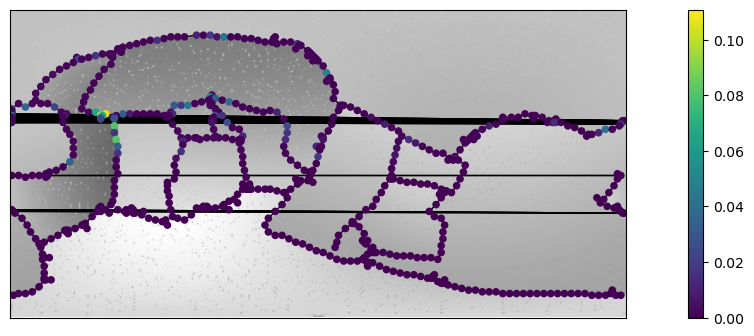

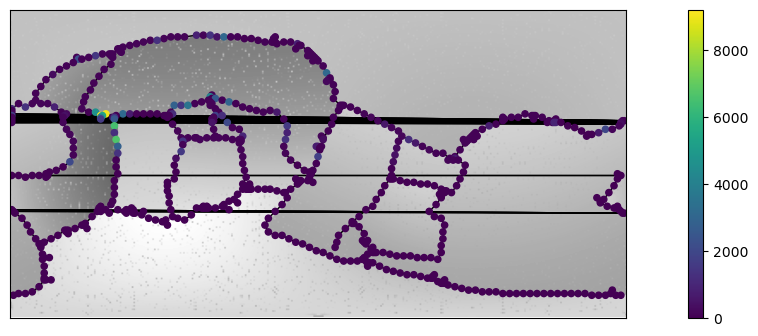

In [80]:
def plot_attribute(G, attribute, ax=None, node_size=20, cmap='viridis'):
    pos = nx.get_node_attributes(G, 'pos')
    values = nx.get_node_attributes(G, attribute)
    nodes = G.nodes()
    node_colors = [values[node] for node in nodes]

    if ax is None:
        fig, ax = plt.subplots()

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, cmap=cmap, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax)
    
# Plot the slip rate in G_slip
fig, ax = plt.subplots(figsize=(16, 4))

# Ensure geographic positions are correctly used for visualization
for node, pos in geographic_positions.items():
    G_slip.nodes[node]['pos'] = pos

plot_attribute(G_slip, 'slip_rate', ax)

# Overlay the interpolated velocity component
ax.imshow(v_x_interp, extent=(lon_min, lon_max, lat_min, lat_max), cmap='gray', origin='lower', alpha=0.6)

# Set limits if needed, based on specific coordinates or data
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])

plt.show()


# Plot the slip in G
fig, ax = plt.subplots(figsize=(16, 4))

# Ensure geographic positions are correctly used for visualization
for node, pos in geographic_positions.items():
    G_displacement.nodes[node]['pos'] = pos

plot_attribute(G_displacement, 'slip', ax)

# Overlay the interpolated velocity component
ax.imshow(v_x_interp, extent=(lon_min, lon_max, lat_min, lat_max), cmap='gray', origin='lower', alpha=0.6)

# Set limits if needed, based on specific coordinates or data
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])

plt.show()


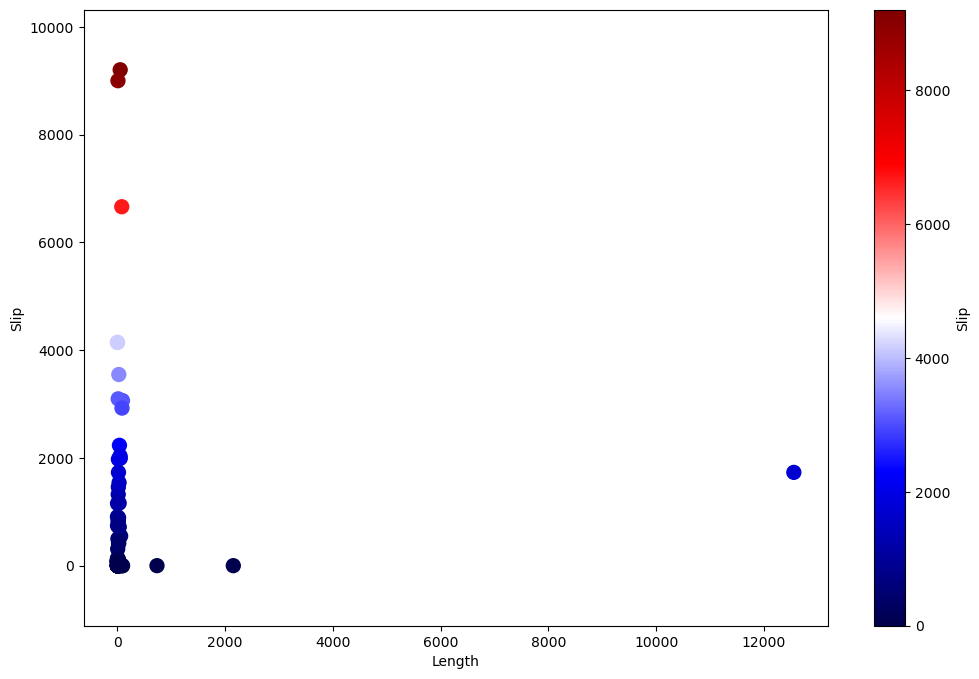

In [81]:
def get_fault_labels(G):
    labels = set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))

def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault'] == n]
    return G.subgraph(nodes)

def total_length(fault):
    length = 0
    for u, v in fault.edges():
        pos_u = fault.nodes[u]['pos']
        pos_v = fault.nodes[v]['pos']
        length += np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)
    return length

labels = get_fault_labels(G_displacement)

lengths = []
slips = []
for label in labels:
    fault = get_fault(G_displacement, label)
    lengths.append(total_length(fault))
    slips.append(np.max([fault.nodes[node]['slip'] for node in fault]))

plt.figure(figsize=(12, 8))
plt.scatter(lengths, slips, c=slips, s=100, cmap='seismic', vmin=0)
plt.xlabel('Length')
plt.ylabel('Slip')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('Slip')
plt.show()
